In [1]:
import argparse  # Commandline input

import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file  # or use curl

# To get info about the GW events
from pycbc.catalog import Catalog, Merger

# used for setting priors or initial points of walkers
from pycbc.distributions import JointDistribution, SinAngle, Uniform

# Signal processing and Matched filtering
from pycbc.filter import highpass, matched_filter, resample_to_delta_t, sigma
from pycbc.frame import read_frame  # read the GW data which is in gwf format

# likelihood and stochastic samplers
from pycbc.inference import models, sampler

# BaseModel is inherited and used to make manual models
from pycbc.inference.models.base import BaseModel

# PSD estimation
from pycbc.psd import interpolate, inverse_spectrum_truncation

# td referes to time domain, there is equivalently frequency domain (get_fd_waveform)
from pycbc.waveform import get_td_waveform, td_approximants, fd_approximants  # Generate GWaveforms
from pycbc import inference  # Used for IO in this file
from scipy.stats import norm
from IPython.display import Image  # Generate image of posterior
from IPython.display import HTML  # Generate summary of the posterior results
from scipy.integrate import quad
import scipy.stats as st

plt.style.use("standard.mplstyle")


In [2]:
print(fd_approximants())

['EccentricFD', 'TaylorF2', 'TaylorF2Ecc', 'TaylorF2NLTides', 'TaylorF2RedSpin', 'TaylorF2RedSpinTidal', 'SpinTaylorF2', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_DoubleSpin_HI', 'Lackey_Tidal_2013_SEOBNRv2_ROM', 'SEOBNRv4_ROM', 'SEOBNRv4HM_ROM', 'SEOBNRv4_ROM_NRTidal', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'SEOBNRv4T_surrogate', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidal', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomP', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'SpinTaylorT4Fourier', 'SpinTaylorT5Fourier', 'NRSur4d2s', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'SpinTaylorF2_SWAPPER', 'TaylorF2NL', 'PreTaylorF2', 'multiband', 'TaylorF2_INTERP', 'SpinTaylorT5', 'SEOBNRv1_ROM_EffectiveSpin_INTERP', 'SEOBNRv1_ROM_DoubleSp

In [3]:
def gw_data(detector, event_name):
    # Download the gravitational wave data for GW170817
    url = "https://www.gw-openscience.org/eventapi/json/GWTC-2/GW190521/v3/{}-{}1_GWOSC_4KHZ_R1-1242440920-4096.gwf"
    # Downloading "H-H1_LOSC_4_V2-1128678884-32.gwf" file or  use curl method to download
    fname = download_file(url.format(detector[0], detector[0]), cache=True)

    m = c["GW190521-v3"]
    # read_frame(file_name, channel_name, start, end); channels names is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1
    data = read_frame(
        fname, f"{detector}:GWOSC-4KHZ_R1_STRAIN", start_time=int(m.time - 260), end_time=int(m.time + 40)
    )
    # Read the data directly from the Gravitational-Wave Frame (GWF) file. or
    # this data can be obtained by m = Merger("GW170817"); data = m.strain("H1")
    # This method by default gets the smallest version of the dataset. If additional data or specific versions are required,
    # use the method which is used in this.py file

    print("Sample rate of the downloaded file is ", data.sample_rate)

    # Convert to a frequency series by taking the data's FFT
    data_freq = data.to_frequencyseries()

    return data, data_freq, fname


c = Catalog("gwtc-2")
event_name = "GW190521-v3"
ifos = ["H1", "L1", "V1"]  # List of observatories we'll analyze
# Storing GW data (timeseries) of all detectors in dictionary format
data = {}
# Storing GW data (frequency domain)  of all detectors in dictionary format
data_freq = {}
psds = {}  # Storing power spectral density  of all detectors in dictionary format
fname = {}
for i in ifos:
    print("Reading GW timeseries and freq domain data for detector ", i)
    data[i], data_freq[i], fname[i] = gw_data(detector=i, event_name=event_name)


Reading GW timeseries and freq domain data for detector  H1
Sample rate of the downloaded file is  4096.0
Reading GW timeseries and freq domain data for detector  L1
Sample rate of the downloaded file is  4096.0
Reading GW timeseries and freq domain data for detector  V1
Sample rate of the downloaded file is  4096.0


In [4]:
print("Mass1 in detector frame ", c["GW190521-v3"].median1d("mass1") * (1 + c["GW190521-v3"].median1d("redshift")))
print("Mass2 in detector frame ", c["GW190521-v3"].median1d("mass2") * (1 + c["GW190521-v3"].median1d("redshift")))


Mass1 in detector frame  156.292
Mass2 in detector frame  113.16000000000001


In [5]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =

[static_params]
mass1 = 155.7
mass2 = 112.45
f_lower = 20.0
approximant = IMRPhenomXPHM
polarization = 0
spin1z = 0.112
spin2z = 0.018

[prior-inclination]
name = sin_angle

[prior-distance]
name = uniform
min-distance = 10
max-distance = 10000

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-ra+dec]
; sky position prior
name = uniform_sky

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""


In [6]:
!echo '{prior_config}' > prior_gw190521.ini
!cat prior_gw190521.ini


[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =

[static_params]
mass1 = 155.7
mass2 = 112.45
f_lower = 20.0
approximant = IMRPhenomXPHM
polarization = 0
spin1z = 0.112
spin2z = 0.018

[prior-inclination]
name = sin_angle

[prior-distance]
name = uniform
min-distance = 10
max-distance = 10000

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-ra+dec]
; sky position prior
name = uniform_sky

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [7]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""


In [8]:
!echo '{sampler_config}' > sampler_gw190521.ini
!cat sampler_gw190521.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [9]:
data_config_gw190521 = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -6
analysis-end-time = 2
strain-high-pass = 15
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN
""".format(
    event_tc=c["GW190521-v3"].time, h1file=fname["H1"], l1file=fname["L1"], v1file=fname["V1"]
)


In [10]:
!echo '{data_config_gw190521}' > data_gw190521.ini
!cat data_gw190521.ini


[data]
instruments = H1 L1 V1
trigger-time = 1242442967.4
analysis-start-time = -6
analysis-end-time = 2
strain-high-pass = 15
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:/home/ash/.astropy/cache/download/url/12f80ba4df74fc6ea7281d6b9ec65878/contents L1:/home/ash/.astropy/cache/download/url/995f03271fdfc6a332432bf811edf3c6/contents V1:/home/ash/.astropy/cache/download/url/2a626694bbb8142baf12489ab93fc7c5/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN



In [11]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 20.
ignore-failed-waveforms =
"""


In [12]:
!echo '{model_config}' > model_gw190521.ini
!cat model_gw190521.ini


[model]
name = single_template
low-frequency-cutoff = 20.
ignore-failed-waveforms =



In [13]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw190521.ini sampler_gw190521.ini prior_gw190521.ini model_gw190521.ini\
    --output-file inference_gw190521.hdf \
    --nprocesses 4 \
    --force    

2022-09-15 11:39:01,677 Using seed 1998
2022-09-15 11:39:01,678 Running with CPU support: 1 threads
2022-09-15 11:39:01,735 Reading configuration file
2022-09-15 11:39:01,740 Setting up model
2022-09-15 11:39:01,745 Setting up priors for each parameter
2022-09-15 11:39:01,746 No sampling_params section read from config file
2022-09-15 11:39:01,747 Loading waveform transforms
2022-09-15 11:39:01,754 Determining analysis times to use
2022-09-15 11:39:01,754 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-15 11:39:01,754 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-15 11:39:01,755 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-15 11:39:01,755 Reading Frames
2022-09-15 11:39:24,025 Highpass Filtering
2022-09-15 11:39:24,045 Resampling data
2022-09-15 11:39

In [28]:
!pycbc_inference_plot_posterior --verbose --input-file inference_gw190521_IMRPhenom.hdf \
        --output-file posterior_gw190521.png \
        --plot-scatter --plot-marginal --z-arg snr

2022-09-12 10:42:57,053 Reading input file inference_gw190521_IMRPhenom.hdf
2022-09-12 10:42:57,055 Loading samples
2022-09-12 10:42:57,243 Loaded 1400 samples
2022-09-12 10:42:57,243 Getting samples for colorbar
2022-09-12 10:42:57,279 Plotting
2022-09-12 10:43:01,193 Done


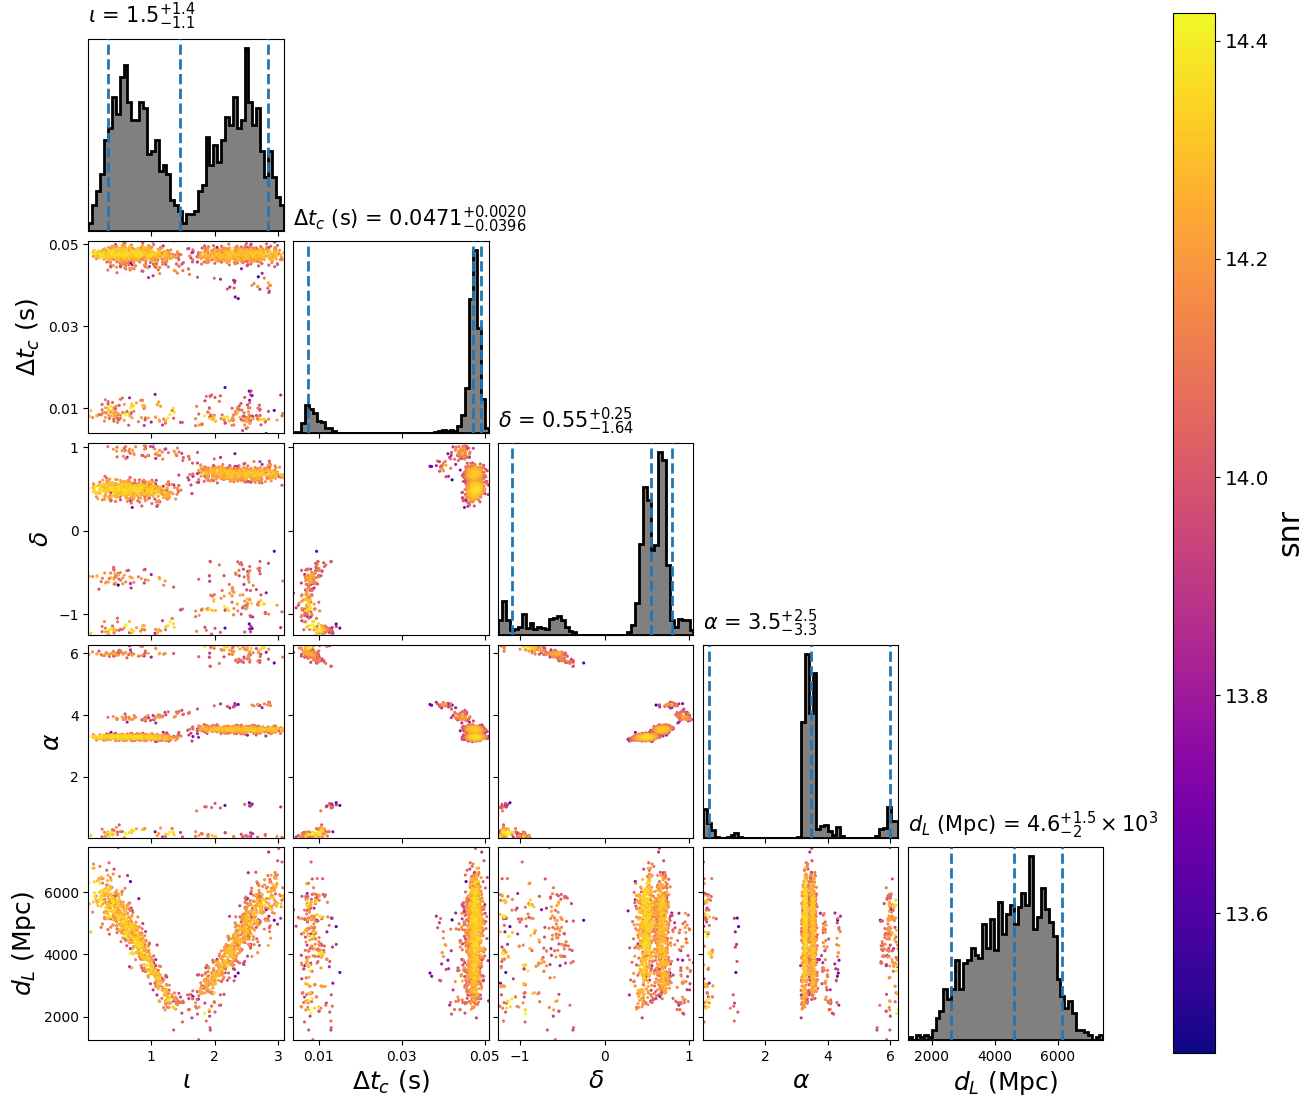

In [29]:
Image("posterior_gw190521.png", height=480)


In [30]:
!pycbc_inference_table_summary \
    --input-file inference_gw190521_IMRPhenom.hdf \
    --output-file posterior_summary.html \
    --verbose

2022-09-12 10:43:08,805 Reading input file inference_gw190521_IMRPhenom.hdf
2022-09-12 10:43:08,808 Loading samples
2022-09-12 10:43:08,853 Loaded 1400 samples


In [31]:
HTML("posterior_summary.html")


Dl is cosmology dependent. Taking flat lambda CDM model with omega_m = 0.3, omega_lambda = 0.7, omega_rad = 0, H0 = 69.8 \
Calculating the luminosity distance by $d_l = \frac{c(1+z)}{H0} \int_{0}^{z} \frac{dz}{H}$\
where $H=\sqrt(\frac{\Omega_{m}}{(1+z)^3}+\frac{\Omega_{rad} }{(1+z)^4}+\Omega_\Lambda)$ 

In [32]:
def int_func(redshift):
    return np.sqrt((omega_m / (1 + redshift) ** 3) + (omega_l))


omega_m = 0.3
omega_l = 0.7
redshift = 0.73
c = 3 * 10**5  # Km/s
H0 = 69.8  # Hubble constant in (Km/s)/Mpc
g = quad(int_func, 0, redshift)
dlth = (1 + redshift) * g[0] * (c / H0)
dlth  # in Mpc


4961.620199557098

In [33]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw190521_IMRPhenom.hdf \
    --output-file posterior-dist_inc_gw190521.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters inclination distance --expected-parameters 'distance:4961.62'

2022-09-12 10:43:16,384 Reading input file inference_gw190521_IMRPhenom.hdf
2022-09-12 10:43:16,387 Loading samples
2022-09-12 10:43:16,402 Loaded 1400 samples
2022-09-12 10:43:16,403 Plotting
2022-09-12 10:43:19,344 Done


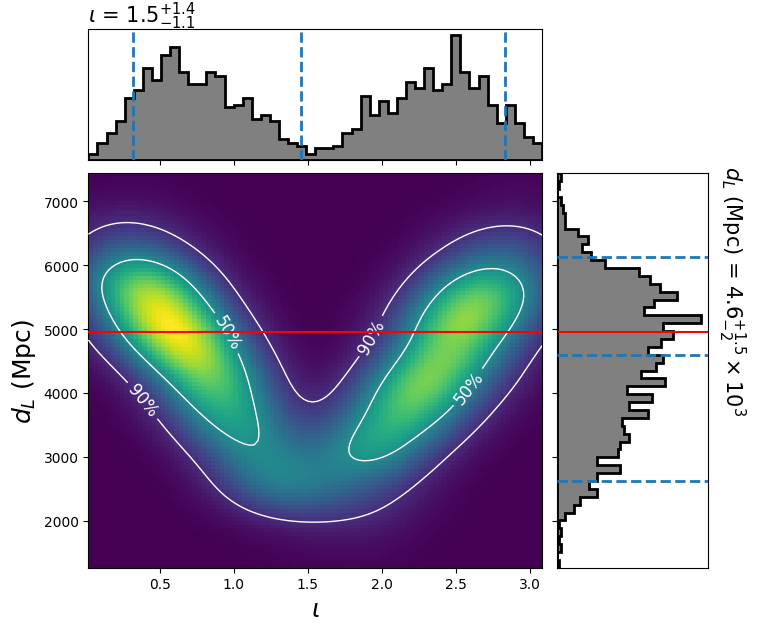

In [34]:
Image("posterior-dist_inc_gw190521.png", height=480)


# Mass1 vs Mass2

In [13]:
model_config_mass_GW190521 = """
[model]
name = relative
low-frequency-cutoff = 20.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 156.292
mass2_ref = 113.16
tc_ref = ${data|trigger-time}
"""


In [14]:
!echo '{model_config_mass_GW190521}' > model_config_mass_GW190521.ini
!cat model_config_mass_GW190521.ini


[model]
name = relative
low-frequency-cutoff = 20.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 156.292
mass2_ref = 113.16
tc_ref = ${data|trigger-time}



In [15]:
prior_config_mass = """
[variable_params]
mass1 = 
mass2 = 
delta_tc = 
distance =
inclination = 
ra =
dec = 
spin1z = 
spin2z = 

[static_params]
f_lower = 20.0
approximant = 
polarization = 0

[prior-inclination]
name = sin_angle

[prior-distance]
name = uniform
min-distance = 10
max-distance = 10000

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-spin1z]
name = uniform
min-spin1z = -1
max-spin1z = 1
;assuming spins are aligned (0 degree) or anti-aligned (180 degree) to L

[prior-spin2z]
name = uniform
min-spin2z = -1
max-spin2z = 1
;assuming spins are aligned (0 degree) or anti-aligned (180 degree) to L

[prior-mass1]
name = uniform
min-mass1 = 100
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 70
max-mass2 = 150

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[constraint-1]
name = custom
constraint_arg = mass1>mass2
; assuming q>1
"""

In [16]:
!echo '{prior_config_mass}' > prior_gw190521_mass.ini
!cat prior_gw190521_mass.ini


[variable_params]
mass1 = 
mass2 = 
delta_tc = 
distance =
inclination = 
ra =
dec = 
spin1z = 
spin2z = 

[static_params]
f_lower = 20.0
approximant = 
polarization = 0

[prior-inclination]
name = sin_angle

[prior-distance]
name = uniform
min-distance = 10
max-distance = 10000

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-spin1z]
name = uniform
min-spin1z = -1
max-spin1z = 1
;assuming spins are aligned (0 degree) or anti-aligned (180 degree) to L

[prior-spin2z]
name = uniform
min-spin2z = -1
max-spin2z = 1
;assuming spins are aligned (0 degree) or anti-aligned (180 degree) to L

[prior-mass1]
name = uniform
min-mass1 = 100
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 70
max-mass2 = 150

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[constraint-1]
name = custom
constraint_arg = mass1>mass2
; assuming q>1



In [ ]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw190521.ini sampler_gw190521.ini prior_gw190521_mass.ini model_config_mass_GW190521.ini\
    --output-file inference_gw190521_IMRPhenom_mass.hdf \
    --nprocesses 4 \
    --force    

2022-09-12 07:59:50,098 Using seed 1998
2022-09-12 07:59:50,099 Running with CPU support: 1 threads
2022-09-12 07:59:50,133 Reading configuration file
2022-09-12 07:59:50,137 Setting up model
2022-09-12 07:59:50,141 Setting up priors for each parameter
2022-09-12 07:59:50,143 Renormalizing distribution for constraints
2022-09-12 07:59:50,681 No sampling_params section read from config file
2022-09-12 07:59:50,682 Loading waveform transforms
2022-09-12 07:59:50,687 Determining analysis times to use
2022-09-12 07:59:50,688 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-12 07:59:50,688 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-12 07:59:50,688 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-12 07:59:50,772 Reading Frames
2022-09-12 08:00:10,689 Highpass

In [39]:
!pycbc_inference_plot_posterior --verbose --input-file inference_gw190521_IMRPhenom_mass.hdf \
        --output-file posterior_gw190521_mass.png \
        --plot-scatter --plot-contours --plot-marginal --z-arg snr

2022-09-12 10:43:28,366 Reading input file inference_gw190521_IMRPhenom_mass.hdf
2022-09-12 10:43:28,369 Loading samples
2022-09-12 10:43:28,728 Loaded 1400 samples
2022-09-12 10:43:28,728 Getting samples for colorbar
2022-09-12 10:43:28,775 Plotting
2022-09-12 10:44:11,881 Done


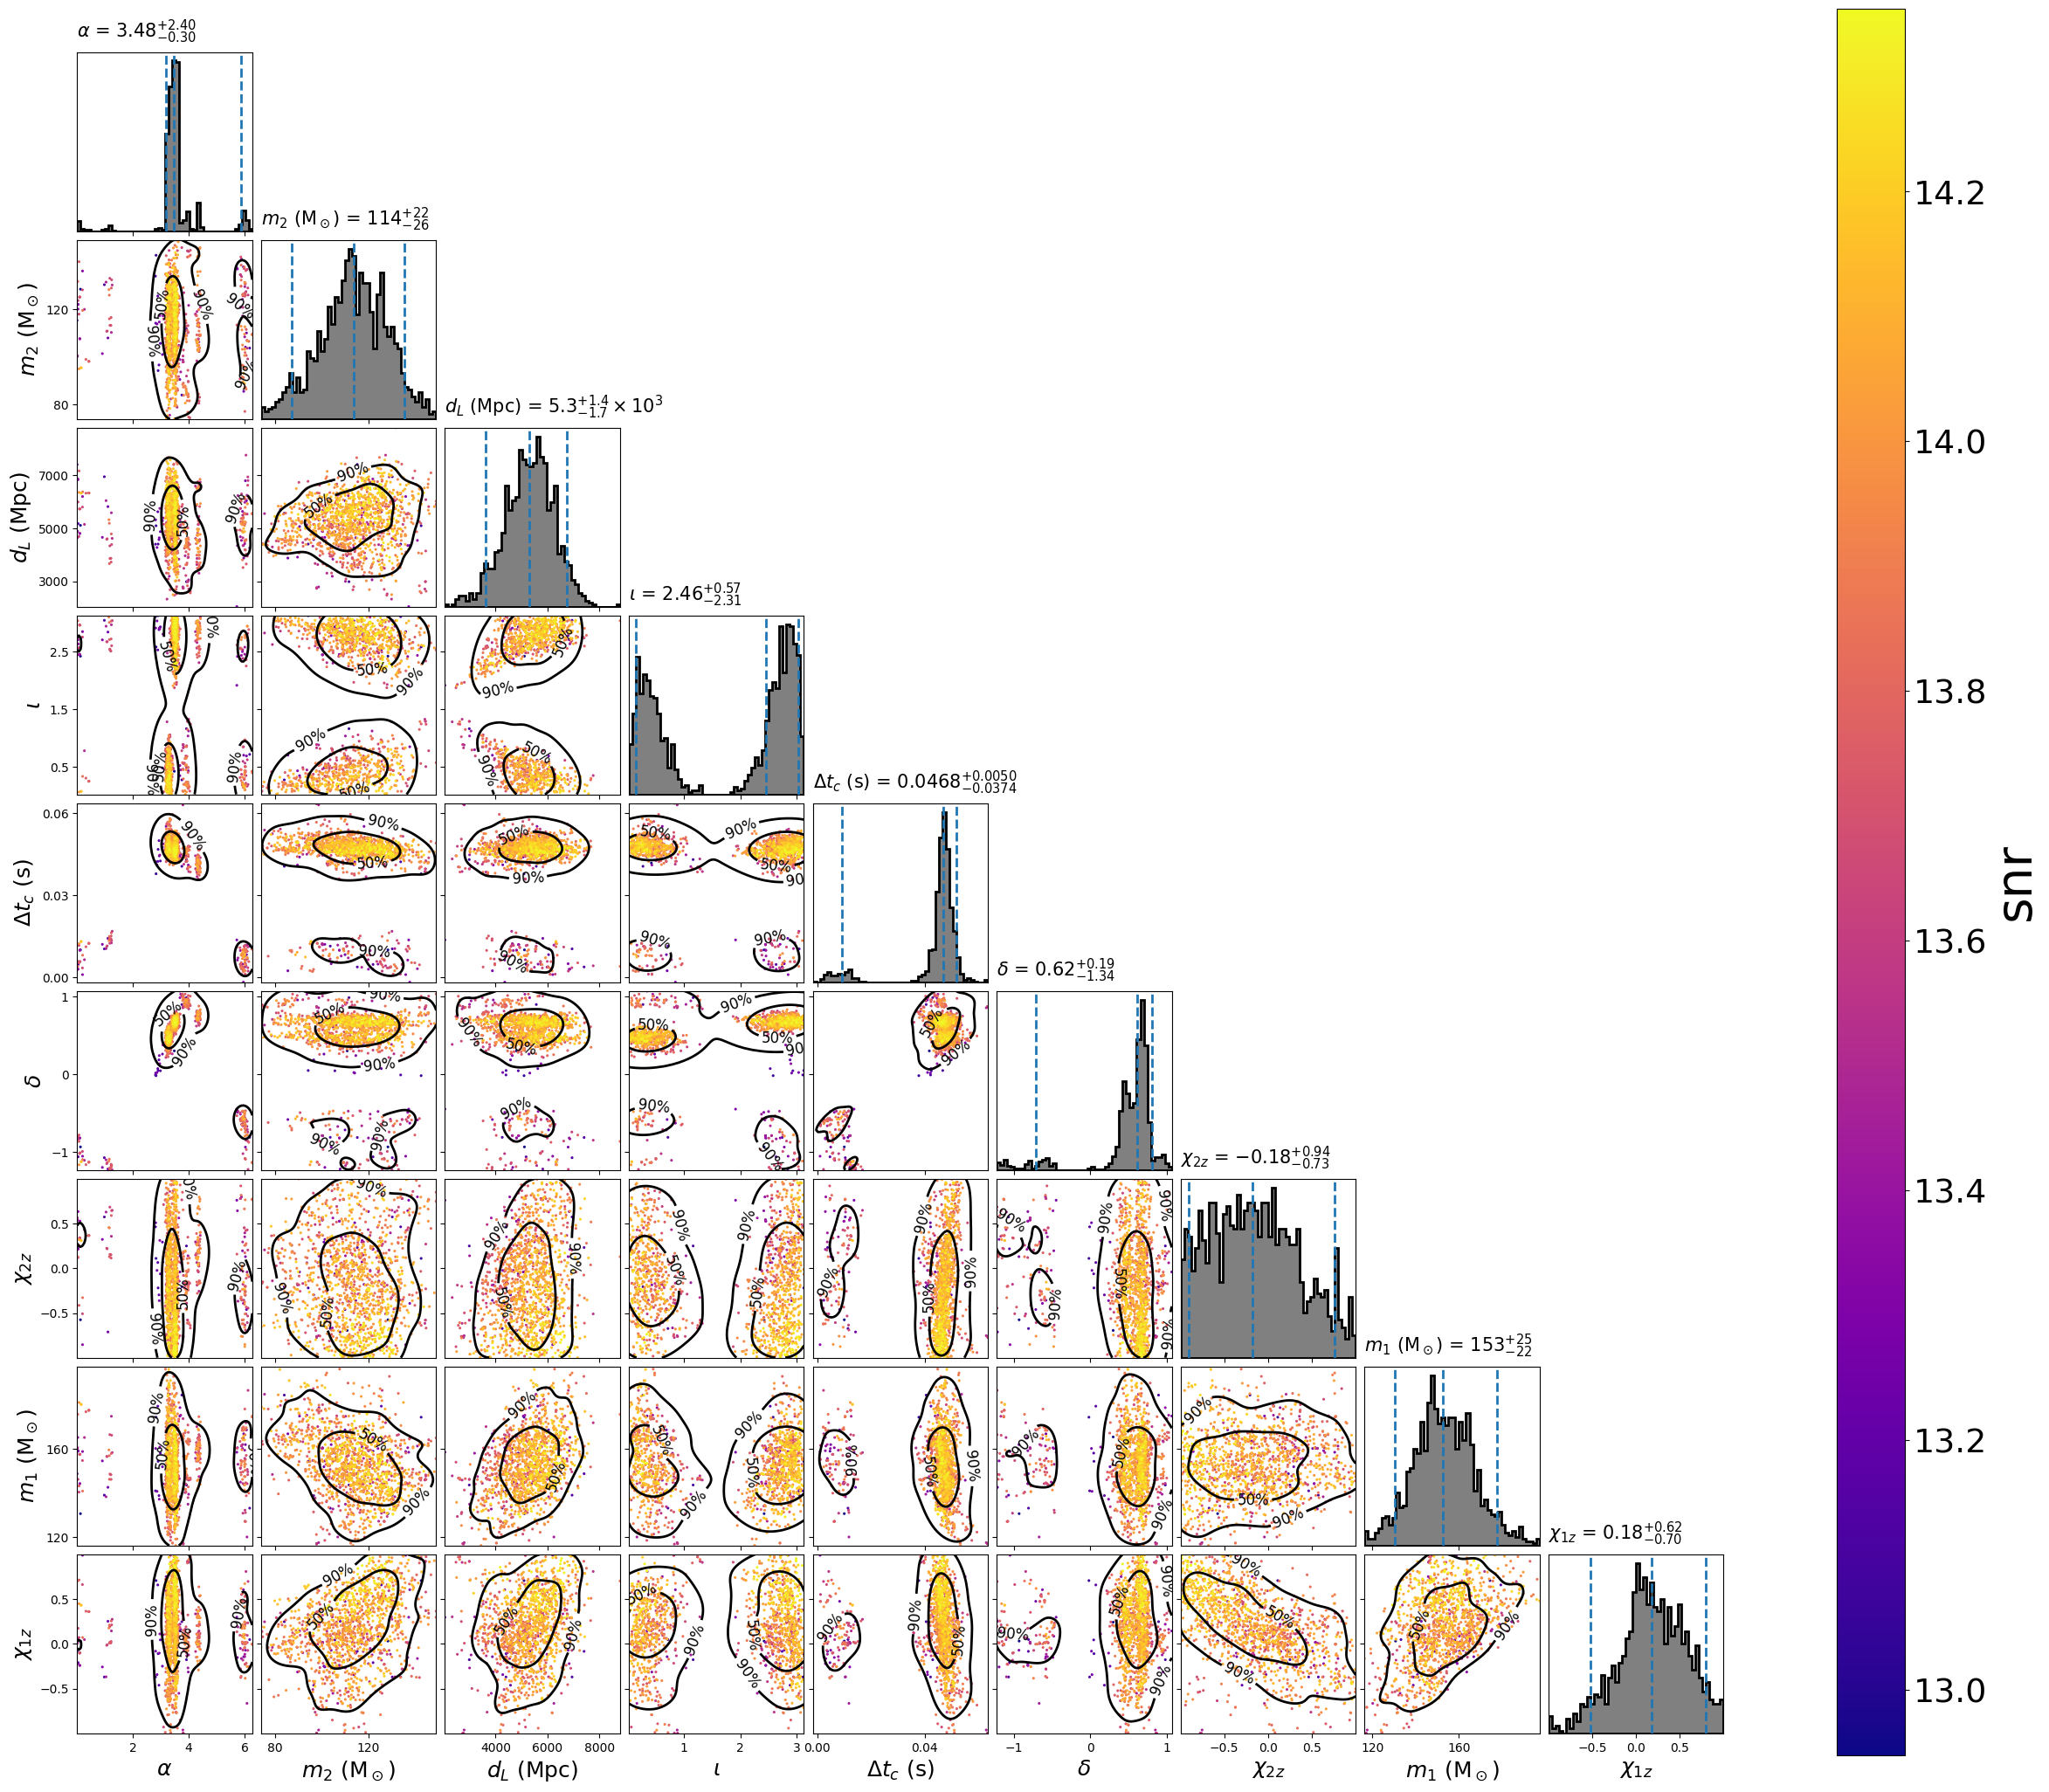

In [40]:
Image("posterior_gw190521_mass.png", height=480)

In [46]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw190521_IMRPhenom_mass.hdf \
    --output-file posterior-mass1-mass2_gw190521.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters mass1 mass2 --expected-parameters 'mass1:155' 'mass2:113'

2022-09-12 10:45:31,470 Reading input file inference_gw190521_IMRPhenom_mass.hdf
2022-09-12 10:45:31,472 Loading samples
2022-09-12 10:45:31,482 Loaded 1400 samples
2022-09-12 10:45:31,482 Plotting
2022-09-12 10:45:34,593 Done


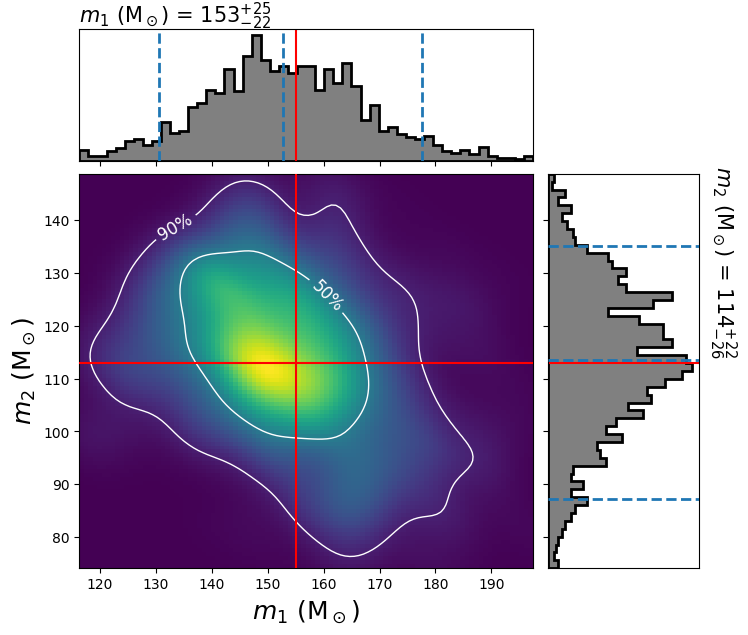

In [47]:
Image("posterior-mass1-mass2_gw190521.png", height=480)

# Plot chains

In [43]:
# !pycbc_inference_plot_samples --verbose \
#     --input-file normal2d.hdf \
#     --output-file samples_chain.png \
#     --parameters x y \
#     --thin-start 0 \
#     --thin-interval 1


# Chi_eff vs q

In [17]:
sampler_config_adv = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""


In [18]:
!echo '{sampler_config_adv}' > sampler_gw190521.ini
!cat sampler_gw190521.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



In [19]:
prior_config_GW190521 = """
[variable_params]
q = 
mass1 = 
chi_eff = 
spin1z =
distance =
ra = 
dec =
inclination =
delta_tc =

[static_params]
f_lower = 20.0
approximant = IMRPhenomXPHM
polarization = 0
; redshit in static??

[prior-distance]
name = uniform
min-distance = 10
max-distance = 10000

[prior-inclination]
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-chi_eff]
name = uniform
min-chi_eff = -1
max-chi_eff = 1

[prior-spin1z]
name = uniform
min-spin1z = -1
max-spin1z = 1
;assuming spins are aligned (0 degree) or anti-aligned (180 degree) to L

[prior-mass1]
name = uniform
min-mass1 = 100
max-mass1 = 190
;assuming mass1 is primary (>) mass (making a constraint mass1>mass2)

[prior-q]
name = uniform
min-q = 0.01
max-q = 0.99
; if q<1 then q is defined as primary mass / secondary mass
; what is primary and secondary mass is decided by constraint i.e. mass1 is primary 

[waveform_transforms-mass2]
name = custom
inputs = mass1, q
mass2 = mass1 * q
; as mass2 should be secondary mass

[waveform_transforms-spin2z]
name = custom
inputs = q, chi_eff, spin1z
spin2z =  ((1+q)*chi_eff - spin1z)/q
min-spin2z = 0
max-spin2z = 1
; as mass2 should be secondary mass

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[constraint-1]
name = custom
constraint_arg = ((1+q)*chi_eff - spin1z)/q < 1 

[constraint-2]
name = custom
constraint_arg = ((1+q)*chi_eff - spin1z)/q > -1 
; assuming spins are aligned to L
"""


In [20]:
!echo '{prior_config_GW190521}' > prior_gw190521.ini
!cat prior_gw190521.ini


[variable_params]
q = 
mass1 = 
chi_eff = 
spin1z =
distance =
ra = 
dec =
inclination =
delta_tc =

[static_params]
f_lower = 20.0
approximant = IMRPhenomXPHM
polarization = 0
; redshit in static??

[prior-distance]
name = uniform
min-distance = 10
max-distance = 10000

[prior-inclination]
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-chi_eff]
name = uniform
min-chi_eff = -1
max-chi_eff = 1

[prior-spin1z]
name = uniform
min-spin1z = -1
max-spin1z = 1
;assuming spins are aligned (0 degree) or anti-aligned (180 degree) to L

[prior-mass1]
name = uniform
min-mass1 = 100
max-mass1 = 190
;assuming mass1 is primary (>) mass (making a constraint mass1>mass2)

[prior-q]
name = uniform
min-q = 0.01
max-q = 0.99
; if q<1 then q is defined as primary mass / secondary mass
; what is primary and secondary mass is decided by constraint i.e. mass1 is primary 

[waveform_transforms-mass2]
name

In [21]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data_gw190521.ini sampler_gw190521.ini prior_gw190521.ini model_config_mass_GW190521.ini\
    --output-file inference_gw190521_IMRPhenom_chieff_q.hdf \
    --nprocesses 4 \
    --force    

2022-09-19 20:00:30,301 Using seed 1998
2022-09-19 20:00:30,302 Running with CPU support: 1 threads
2022-09-19 20:00:30,360 Reading configuration file
2022-09-19 20:00:30,366 Setting up model
2022-09-19 20:00:30,371 Setting up priors for each parameter
2022-09-19 20:00:30,375 Renormalizing distribution for constraints
2022-09-19 20:00:31,500 No sampling_params section read from config file
2022-09-19 20:00:31,500 Loading waveform transforms
2022-09-19 20:00:31,607 Determining analysis times to use
2022-09-19 20:00:31,607 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-19 20:00:31,607 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-19 20:00:31,608 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2022-09-19 20:00:31,609 Reading Frames
2022-09-19 20:00:52,432 Highpass

# Theoretical values from paper

In [31]:
spin1 = 0.65  # given values
spin2 = 0.53  # given values
spin1z = np.cos(80 * np.pi / 180) * spin1  # 80 radian is the polar angle between L and S
spin2z = np.cos(88 * np.pi / 180) * spin2  # 88 radian is the polar angle between L and S
print("Spin1z and Spin2z are ", spin1z, spin2z)
mass1 = 155.7  # in detector frame
mass2 = 112.45
q = mass2 / mass1
print("q", q)
chi_eff = ( spin1z + q*spin2z) / (1 + q)
print("Chi_eff", chi_eff)


Spin1z and Spin2z are  0.11287131548350478 0.018496733252325575
q 0.7222222222222223
Chi_eff 0.07329487777365543


In [23]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw190521_IMRPhenom_chieff_q.hdf \
    --output-file posterior_gw190521.png \
    --plot-scatter --plot-contours --plot-marginal \
    --z-arg snr 

2022-09-19 20:18:13,181 Reading input file inference_gw190521_IMRPhenom_chieff_q.hdf
2022-09-19 20:18:13,184 Loading samples
2022-09-19 20:18:13,266 Loaded 1400 samples
2022-09-19 20:18:13,266 Getting samples for colorbar
2022-09-19 20:18:13,276 Plotting
2022-09-19 20:18:56,929 Done


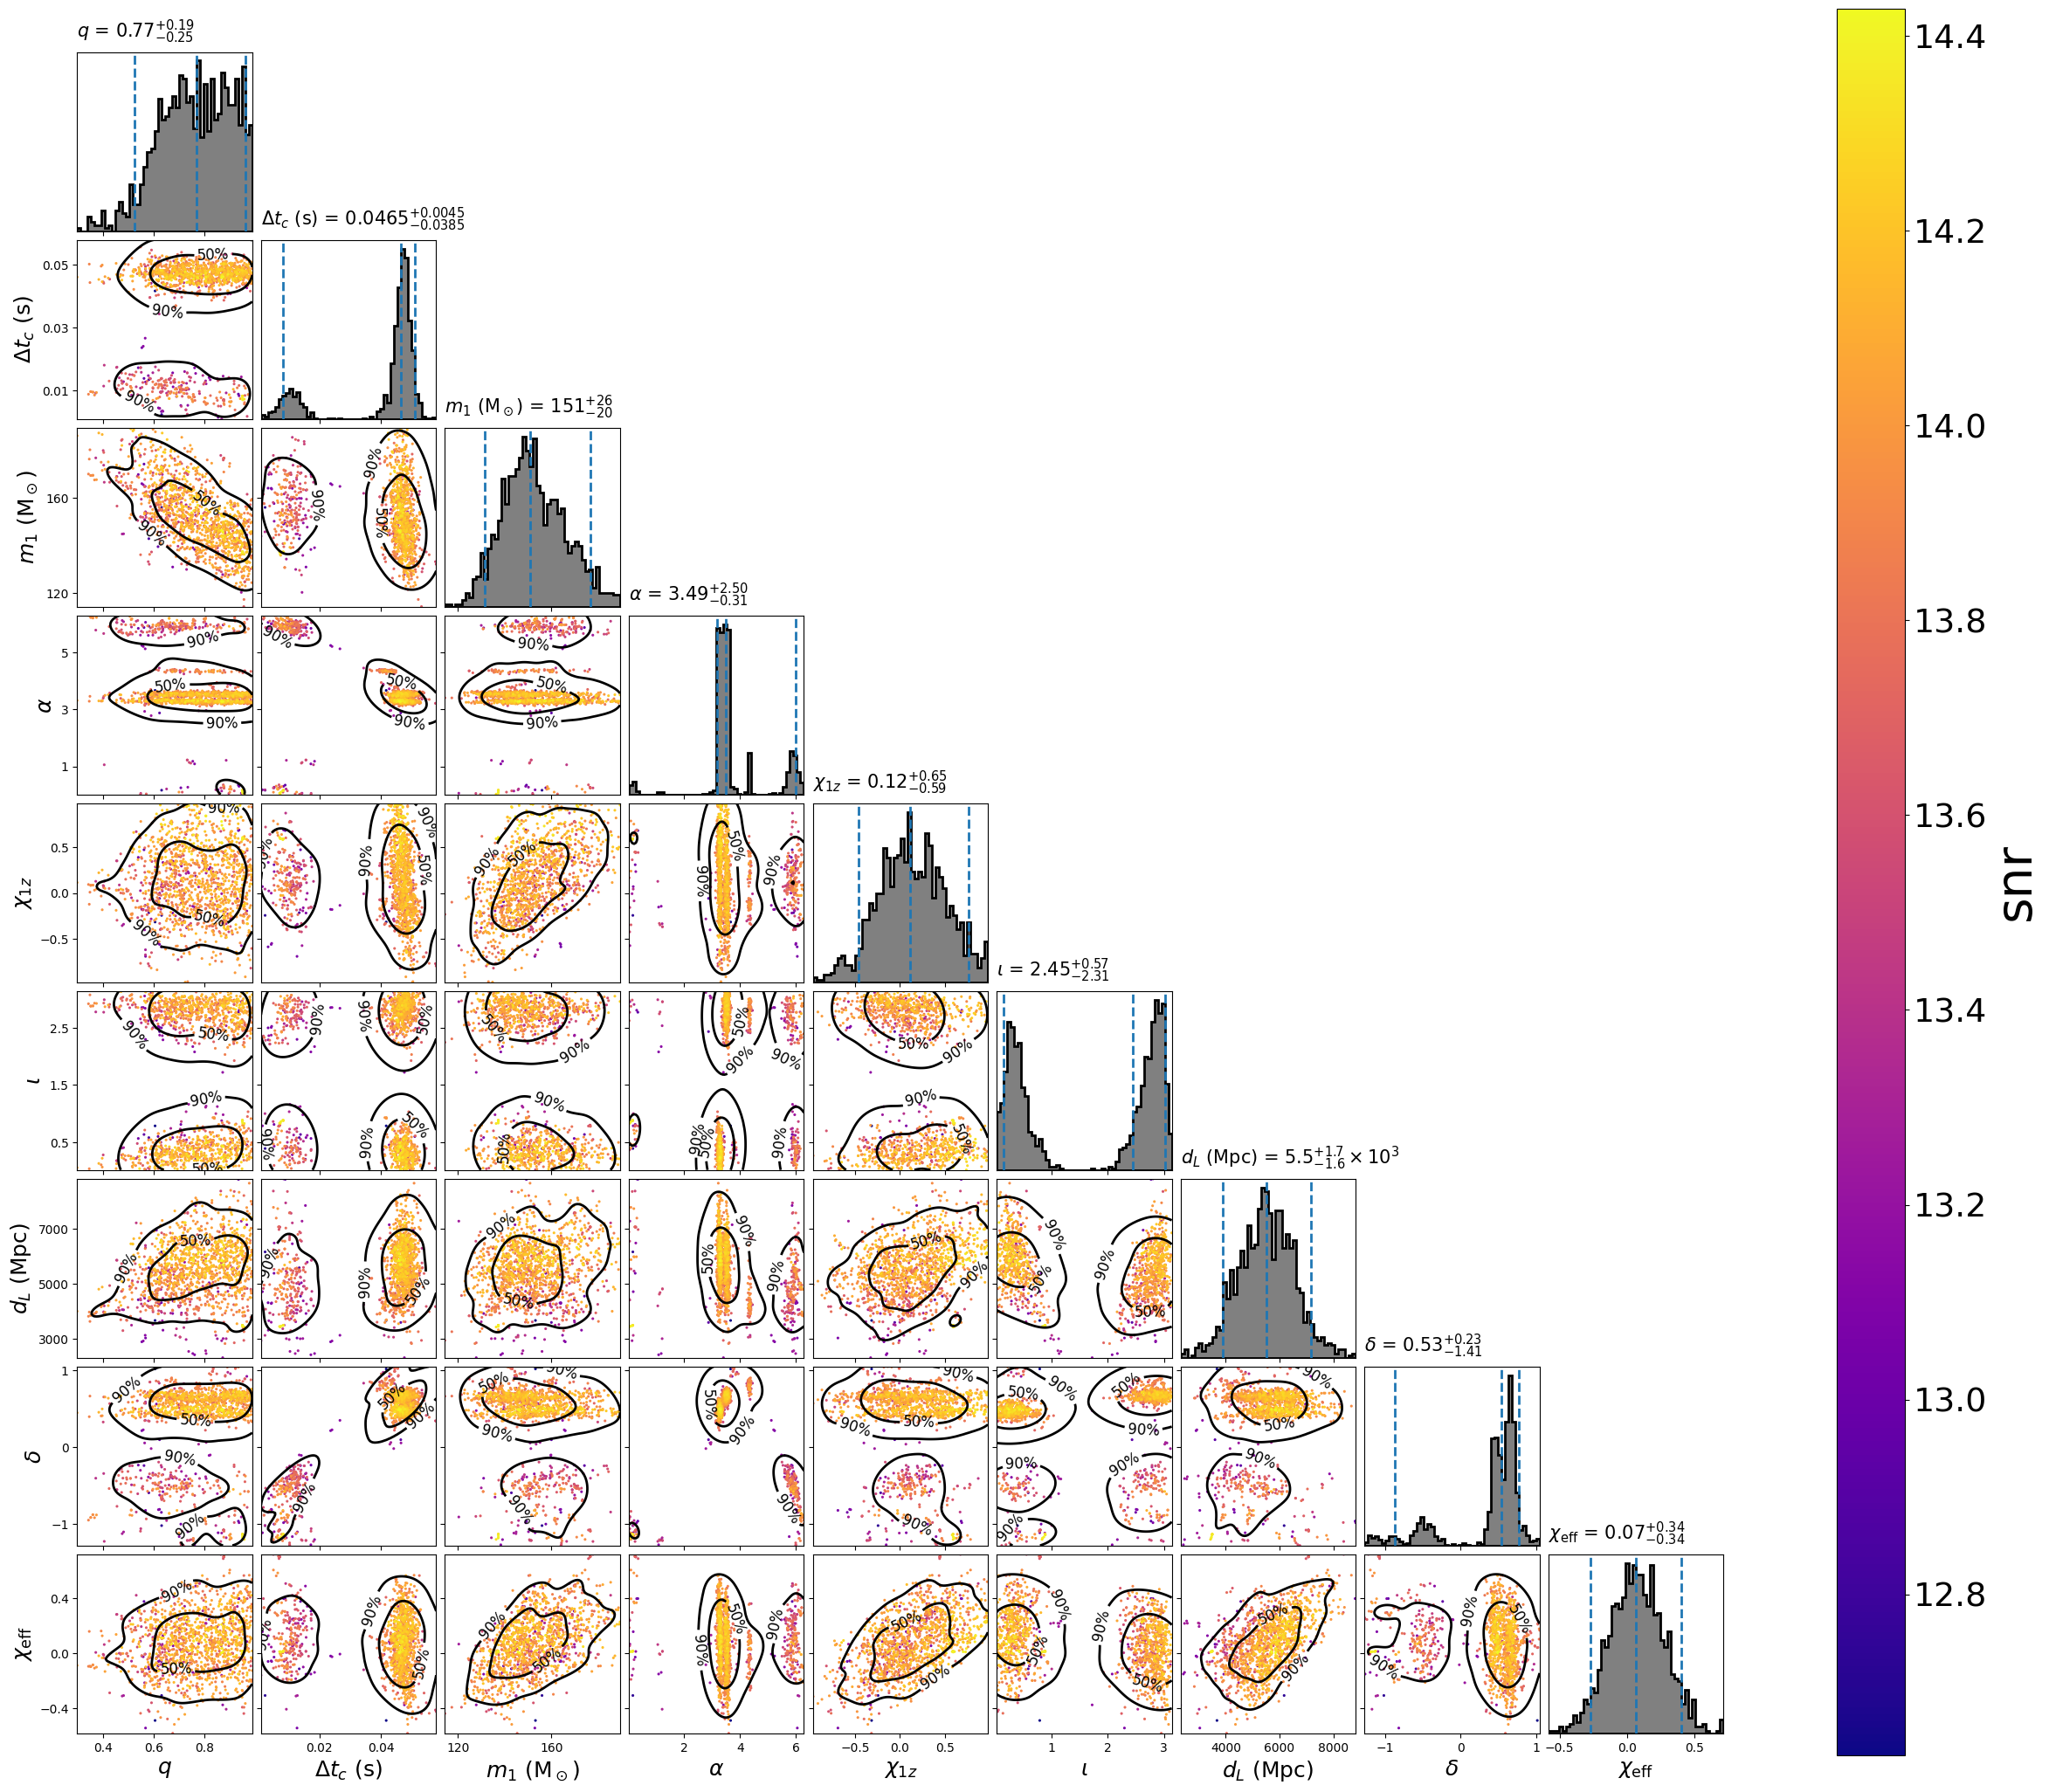

In [24]:
Image("posterior_gw190521.png", height=480)

In [27]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference_gw190521_IMRPhenom_chieff_q.hdf \
    --output-file posterior_gw190521.png \
    --plot-density --plot-contours --plot-marginal \
    --z-arg snr \
    --parameters q chi_eff --expected-parameters 'q:0.72' 'chi_eff:0.07'

2022-09-19 20:19:47,645 Reading input file inference_gw190521_IMRPhenom_chieff_q.hdf
2022-09-19 20:19:47,647 Loading samples
2022-09-19 20:19:47,657 Loaded 1400 samples
2022-09-19 20:19:47,657 Getting samples for colorbar
2022-09-19 20:19:47,666 Plotting
2022-09-19 20:19:49,655 Done


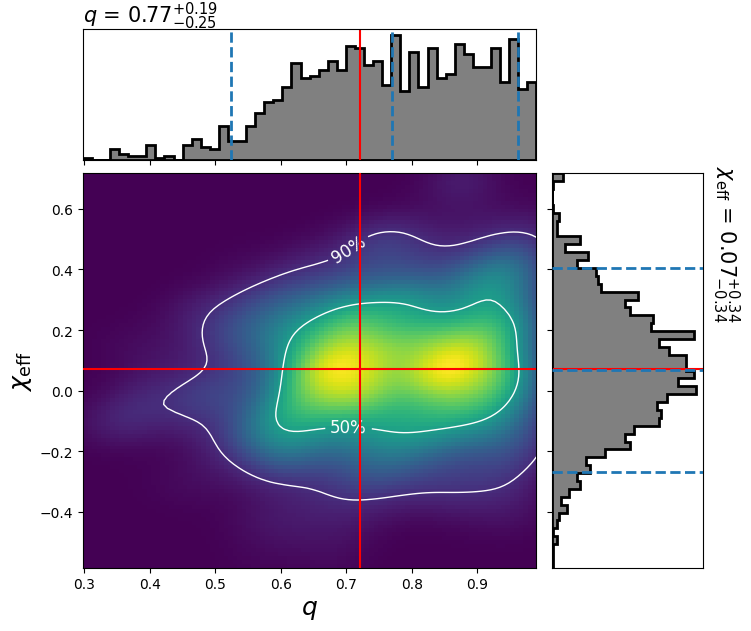

In [28]:
Image("posterior_gw190521.png", height=480)


In [15]:
import hashlib
import h5py 
posterior_samples_file='GW190521_posterior_samples.h5'
print("md5sum",posterior_samples_file,"=",hashlib.md5(open(posterior_samples_file,'rb').read()).hexdigest())
samples_file = h5py.File(posterior_samples_file,'r')
print(samples_file.keys())
print(samples_file['SEOBNRv4PHM'].keys())

seob = samples_file['SEOBNRv4PHM']['posterior_samples']

prior = samples_file['NRSur7dq4']['priors']['samples']

md5sum GW190521_posterior_samples.h5 = 8af9bce0b55b5ebed7853dbfaa69a2d5
<KeysViewHDF5 ['IMRPhenomPv3HM', 'NRSur7dq4', 'SEOBNRv4PHM', 'history', 'version']>
<KeysViewHDF5 ['approximant', 'calibration_envelope', 'config_file', 'injection_data', 'meta_data', 'posterior_samples', 'priors', 'psds', 'version']>


# Analysis of Inference file 

In [34]:
fp = inference.io.loadfile("inference_gw190521_IMRPhenom_chieff_q.hdf", "r")
print(fp.keys())
print(fp["samples"].keys())
samples = fp.read_samples(fp["samples"], temps=0)
print(samples)
mass1 = samples["mass1"]
spin1z = samples["spin1z"]
q = samples["q"]
chi_eff = samples["chi_eff"]
loglikelihood = samples["loglikelihood"]
print(np.max(loglikelihood))
print(np.min(loglikelihood))
print(np.max(loglikelihood) - 8)
# https://ned.ipac.caltech.edu/level5/Wall2/Wal3_4.html
# In our case DOF = 4 and 90% credible interval would be equivalent to around 8


<KeysViewHDF5 ['config_file', 'data', 'sampler_info', 'samples']>
<KeysViewHDF5 ['chi_eff', 'dec', 'delta_tc', 'distance', 'inclination', 'logjacobian', 'loglikelihood', 'logprior', 'mass1', 'q', 'ra', 'spin1z']>
[(-0.3787331 , 5.93709183, 0., -116623.93611056,  0.28683449, 0.01383542, -16.23061053,  0.31216417, 0.6666728 , 0.55245285, 157.85727031, 5240.33243921)
 ( 0.49002034, 3.43571626, 0., -116630.73236528, -0.09466802, 0.05101858, -16.20908472, -0.09626075, 0.6176767 , 0.60000019, 139.54803214, 5189.36367692)
 ( 0.47353625, 3.30081471, 0., -116616.73298872,  0.10434274, 0.05136743, -16.62589923, -0.1568341 , 0.85467895, 0.37791799, 136.22441974, 6328.31371736)
 ...
 ( 0.48382841, 3.29211383, 0., -116611.46561952,  0.12811493, 0.04611723, -16.39157445,  0.84542636, 0.80685147, 0.4880638 , 157.53871345, 5996.09281046)
 ( 0.4085687 , 3.24540689, 0., -116612.80342078,  0.09332753, 0.04615639, -17.08336214,  0.60165592, 0.77107132, 0.22845234, 155.80356228, 5725.2841812 )
 ( 0.4744367

# Entropies E1 and E2

In [35]:
E1 = (mass1**2) * (
    1 + np.sqrt(1 - np.abs(spin1z) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
mass2 = mass1 * q
spin2z = ((1+q)*chi_eff - spin1z)/q
print("Limit of spin2z is ", np.min(spin2z), np.max(spin2z))
E2 = (mass2**2) * (1 + np.sqrt(1 - np.abs(spin2z) ** 2))  # Initial Entropy of BH2


Limit of spin2z is  -0.9970986959687247 0.9993576977367433


# Removing unphysical spin2z and corresponding spin1z, mass1, mass2

In [63]:
# # Run it only once
# mass1 = mass1[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# spin1z = spin1z[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# q = q[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# chi_eff = chi_eff[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# mass2 = mass2[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# loglikelihood = loglikelihood[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# spin2z = spin2z[
#     np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))
# ]  # Note: keep this at end otherwise spin2z would change
# mass1.shape


In [64]:
# E1 = (mass1**2) * (
#     1 + np.sqrt(1 - np.abs(spin1z) ** 2)
# )  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
# mass2 = q * mass1
# spin2z = (chi_eff * (1 + q) - spin1z) / q
# E2 = (mass2**2) * (1 + np.sqrt(1 - np.abs(spin2z) ** 2))  # Initial Entropy of BH2


# Extracting 90/% credible interval

In [65]:
# # Run it only once
# binsize = 50
# n, bins, patches = plt.hist(loglikelihood, bins=binsize, density=True)

# print("Length before removing ", len(loglikelihood))
# plt.ylabel("PDF")
# plt.xlabel("loglikelihood")
# plt.title("likelihood histogram")
# plt.show()

# lower = np.percentile(loglikelihood, 50 - 90 / 2)
# upper = np.percentile(loglikelihood, 50 + 90 / 2)
# loglikelihood = loglikelihood[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# q = q[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# chi_eff = chi_eff[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# mass1 = mass1[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# spin1z = spin1z[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]

# samples = samples[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# print("Samples of 90 \%credible region ", samples)
# print("Length after removing ", len(loglikelihood))

# n, bins, patches = plt.hist(loglikelihood, bins=binsize, density=True)
# plt.title("likelihood histogram 90% credible interval")
# plt.ylabel("PDF")
# plt.xlabel("loglikelihood")
# plt.show()


In [66]:
# plt.scatter(q, chi_eff, c=loglikelihood)
# plt.xlabel("q")
# plt.ylabel("$\chi_{eff}$")
# cbar = plt.colorbar()
# cbar.set_label("loglikelihood")
# plt.show()


# Ringdown

In [37]:
for model_name in models.models:
    print(model_name)


test_eggbox
test_normal
test_rosenbrock
test_volcano
test_posterior
test_prior
gaussian_noise
marginalized_phase
marginalized_polarization
marginalized_hmpolphase
brute_parallel_gaussian_marginalize
gated_gaussian_noise
gated_gaussian_margpol
single_template
relative
hierarchical
multi_signal


To do a BH ringdown analysis we need to use one of the gated Gaussian models. Note that there are two: the standard `gated_gaussian_noise` model, and a `gated_gaussian_margpol`. The latter does the same thing, it just marginalizes over the polarization angle numerically to speed up convergence. We'll use that model here

In [38]:
model_config_ringdown = """
[model]
name = gated_gaussian_margpol
low-frequency-cutoff = 15
"""


In [39]:
!echo '{model_config_ringdown}' > model_GW190521_ringdown.ini
!cat model_GW190521_ringdown.ini


[model]
name = gated_gaussian_margpol
low-frequency-cutoff = 15



In [40]:
c = Catalog("gwtc-2")
data_config_ringdown = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -4
analysis-end-time = 4
data-conditioning-low-freq = H1:0 L1:0 V1:0
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN
sample-rate = 2048
strain-high-pass = 15
pad-data = 8
""".format(event_tc=c["GW190521-v3"].time, h1file=fname["H1"], l1file=fname["L1"], v1file=fname["V1"])


In [41]:
!echo '{data_config_ringdown}' > data_GW190521_ringdown.ini
!cat data_GW190521_ringdown.ini


[data]
instruments = H1 L1 V1
trigger-time = 1242442967.4
analysis-start-time = -4
analysis-end-time = 4
data-conditioning-low-freq = H1:0 L1:0 V1:0
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
frame-files = H1:/home/ash/.astropy/cache/download/url/12f80ba4df74fc6ea7281d6b9ec65878/contents L1:/home/ash/.astropy/cache/download/url/995f03271fdfc6a332432bf811edf3c6/contents V1:/home/ash/.astropy/cache/download/url/2a626694bbb8142baf12489ab93fc7c5/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN
sample-rate = 2048
strain-high-pass = 15
pad-data = 8



In [42]:
HTML("posterior_summary.html")


In [43]:
prior_config_ringdown = """
[static_params]
approximant = TdQNMfromFinalMassSpin
harmonics = spheroidal
tref = ${data|trigger-time}
ra = 3.5
dec = 0.73
toffset = 0.018
; time after merger when ringown (linear regime) starts
lmns = 222
t_final = 2 

[variable_params]
; ref_amp (str, optional) - Which mode to use as the reference for computing amplitudes
final_mass = 
final_spin = 
inclination = 
logamp220 = 
; if ref_amp = 'amp220', lmns = ['221', '331'], and no distance is provided, then amp220 = 1e-22, amp330 = 0.1 would result in the 220 mode
;  having a strain amplitude of 1e-22 and the 330 mode having a strain amplitude of 1e-23.
phi220 =
amp221 =
phi221 =

[waveform_transforms-t_gate_end]
name = custom
inputs = tref
t_gate_end = tref + 0.0

[waveform_transforms-t_gate_start]
name = custom
inputs = t_gate_end
t_gate_start = t_gate_end - 2

[waveform_transforms-tc]
name = custom
inputs = t_gate_end
tc = t_gate_end - 0.001

[prior-final_mass]
name = uniform
min-final_mass = 100
max-final_mass = 500

[prior-final_spin]
name = uniform
min-final_spin = -0.99
max-final_spin = 0.99

[prior-inclination]
name = sin_angle

[prior-logamp220]
name = uniform
min-logamp220 = -24
max-logamp220 = -19

[waveform_transforms-amp220]
name = custom
inputs = logamp220
amp220 = 10**logamp220

[prior-phi220]
name = uniform_angle

[prior-amp221]
name = uniform
min-amp221 = 0
max-amp221 = 5

[prior-phi221]
name = uniform_angle
"""


In [44]:
!echo '{prior_config_ringdown}' > prior_GW190521_ringdown.ini
!cat prior_GW190521_ringdown.ini


[static_params]
approximant = TdQNMfromFinalMassSpin
harmonics = spheroidal
tref = ${data|trigger-time}
ra = 3.5
dec = 0.73
toffset = 0.018
; time after merger when ringown (linear regime) starts
lmns = 222
t_final = 2 

[variable_params]
; ref_amp (str, optional) - Which mode to use as the reference for computing amplitudes
final_mass = 
final_spin = 
inclination = 
logamp220 = 
; if ref_amp = amp220, lmns = [221, 331], and no distance is provided, then amp220 = 1e-22, amp330 = 0.1 would result in the 220 mode
;  having a strain amplitude of 1e-22 and the 330 mode having a strain amplitude of 1e-23.
phi220 =
amp221 =
phi221 =

[waveform_transforms-t_gate_end]
name = custom
inputs = tref
t_gate_end = tref + 0.0

[waveform_transforms-t_gate_start]
name = custom
inputs = t_gate_end
t_gate_start = t_gate_end - 2

[waveform_transforms-tc]
name = custom
inputs = t_gate_end
tc = t_gate_end - 0.001

[prior-final_mass]
name = uniform
min-final_mass = 100
max-final_mass = 500

[prior-final_spi

In [45]:
!wget https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf 

--2022-09-19 20:25:04--  https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf [following]
--2022-09-19 20:25:05--  https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8562013 (8.2M) [application/octet-stream]
Saving to: ‘KERR-220-07MS.hdf.6’

KERR-220-07MS.hdf.6 100%[===================>]   8.17M  1.34MB/s   

In [46]:
!pycbc_inference_plot_posterior --verbose \
    --input-file KERR-220-07MS.hdf  \
    --output-file completed_scatter.png \
    --plot-scatter --plot-marginal \
    --z-arg loglikelihood

2022-09-19 20:25:22,945 Reading input file KERR-220-07MS.hdf
2022-09-19 20:25:22,947 Loading samples
2022-09-19 20:25:23,038 Loaded 70402 samples
2022-09-19 20:25:23,038 Getting samples for colorbar
2022-09-19 20:25:23,055 Plotting
2022-09-19 20:25:35,928 Done


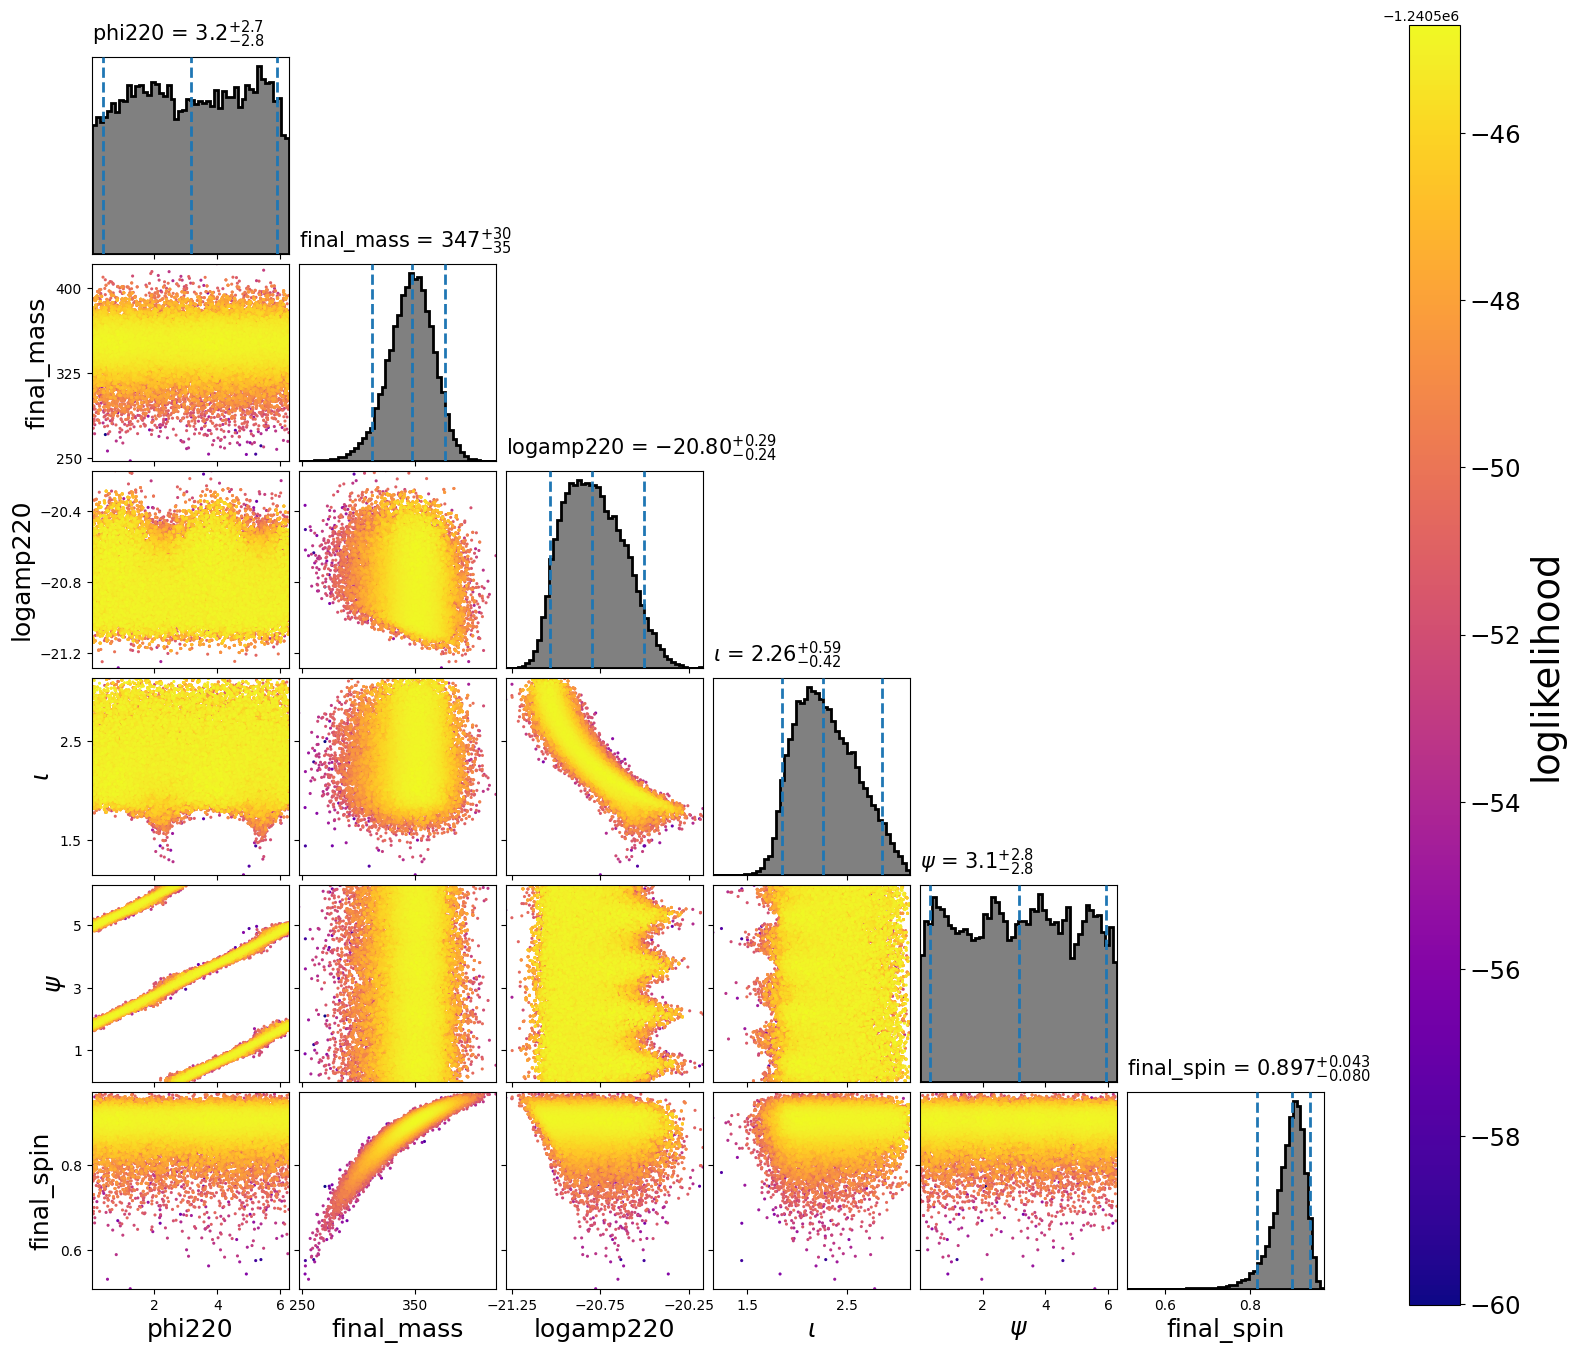

In [47]:
Image("completed_scatter.png", height=480)


In [48]:
!wget https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf 

--2022-09-19 20:25:37--  https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf [following]
--2022-09-19 20:25:38--  https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8562013 (8.2M) [application/octet-stream]
Saving to: ‘KERR-220-07MS.hdf.7’

KERR-220-07MS.hdf.7 100%[===================>]   8.17M  1.67MB/s   

In [49]:
!pycbc_inference_plot_posterior --help

usage: pycbc_inference_plot_posterior [-h] [--input-file FILE[:LABEL]
                                      [FILE[:LABEL] ...]] [-H]
                                      [--parameters PARAM[:LABEL]
                                      [PARAM[:LABEL] ...]]
                                      [--constraint CONSTRAINT[:FILE]
                                      [CONSTRAINT[:FILE] ...]] [--version]
                                      [--output-file OUTPUT_FILE] [--verbose]
                                      [--plot-prior PLOT_PRIOR [PLOT_PRIOR ...]]
                                      [--prior-nsamples PRIOR_NSAMPLES]
                                      [--plot-marginal]
                                      [--marginal-percentiles MARGINAL_PERCENTILES [MARGINAL_PERCENTILES ...]]
                                      [--no-marginal-lines]
                                      [--no-marginal-titles] [--plot-scatter]
                                      [--plot-density] [--plo

In [50]:
!pycbc_inference_plot_posterior --verbose \
    --input-file KERR-220-07MS.hdf  KERR-220_221-07MS.hdf \
    --output-file completed_density-mass_spinKERR-220-07MS.png \
    --plot-contours --plot-marginal \
    --density-cmap inferno --contour-colors white \
    --max-kde-samples 5000 \
    --legend-location 'lower right'\
    --parameters \
        'final_mass:$M_f (M_\odot)$' \
        'final_spin:$\chi_f$' --expected-parameters 'final_mass:254.31' 'final_spin:0.72'

2022-09-19 20:25:58,421 Reading input file KERR-220-07MS.hdf
2022-09-19 20:25:58,422 Loading samples
2022-09-19 20:25:58,430 Loaded 70402 samples
2022-09-19 20:25:58,430 Reading input file KERR-220_221-07MS.hdf
2022-09-19 20:25:58,432 Loading samples
2022-09-19 20:25:58,497 Loaded 83428 samples
2022-09-19 20:25:58,499 Plotting
2022-09-19 20:26:07,727 Done


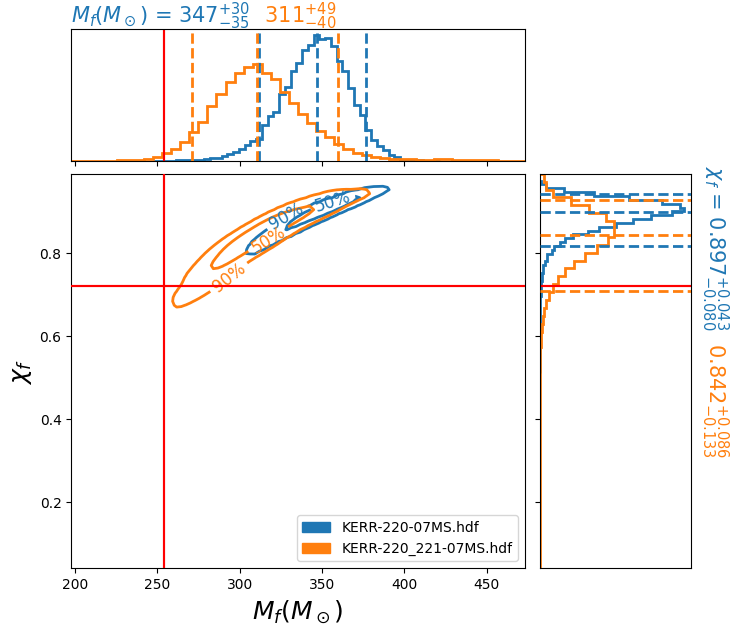

In [51]:
Image("completed_density-mass_spinKERR-220-07MS.png", height=480)


# Depends on tref i.e. starting time of Ringdown

# IO read of Ringdown

In [52]:
fp220221 = inference.io.loadfile("KERR-220_221-07MS.hdf", "r")
fp220 = inference.io.loadfile("KERR-220-07MS.hdf", "r")


In [53]:
samplesr = fp220.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
print(samplesr)

loglikelihood = samplesr["loglikelihood"]
final_mass = samplesr["final_mass"]
final_spin = samplesr["final_spin"]

print("Length ", len(loglikelihood))


[(-1240546.30258507, 0.84537615, 326.0285885 )
 (-1240546.84687439, 0.87183188, 337.00769959)
 (-1240545.40375974, 0.9124024 , 362.65870371) ...
 (-1240545.41318306, 0.8957326 , 343.8156648 )
 (-1240545.9336518 , 0.89684892, 341.62604978)
 (-1240546.61876556, 0.90864241, 361.78911151)]
Length  70402


# Final Entropy

In [54]:
samples220 = fp220.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
samples220221 = fp220221.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)


loglikelihood220 = samples220["loglikelihood"]
final_mass220 = samples220["final_mass"]
final_spin220 = samples220["final_spin"]

Ef220 = (final_mass220**2) * (
    1 + np.sqrt(1 - np.abs(final_spin220) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
print(E1.shape, E2.shape, Ef220.shape)
Ef220 = Ef220.reshape(
    1, Ef220.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2
E1 = E1.reshape(E1.shape[0], 1)
E2 = E2.reshape(E2.shape[0], 1)


loglikelihood220221 = samples220221["loglikelihood"]
final_mass220221 = samples220221["final_mass"]
final_spin220221 = samples220221["final_spin"]

Ef220221 = (final_mass220221**2) * (
    1 + np.sqrt(1 - np.abs(final_spin220221) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
print(E1.shape, E2.shape, Ef220221.shape)
Ef220221 = Ef220221.reshape(
    1, Ef220221.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2


(1400,) (1400,) (70402,)
(1400, 1) (1400, 1) (83428,)


# Merger Entropy Index

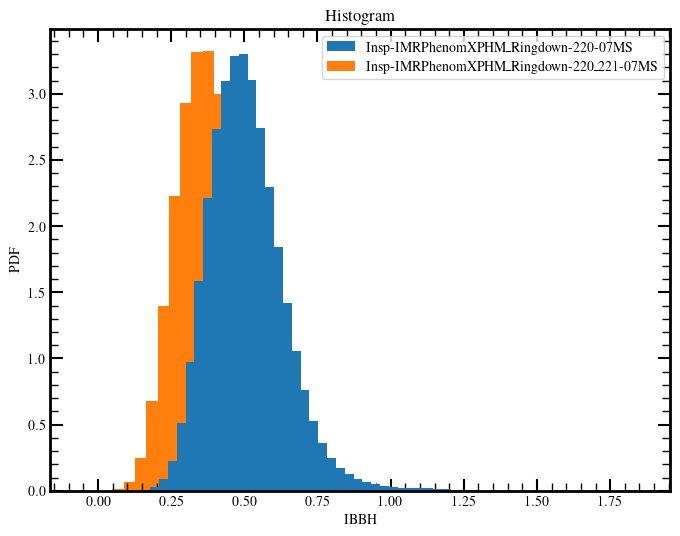

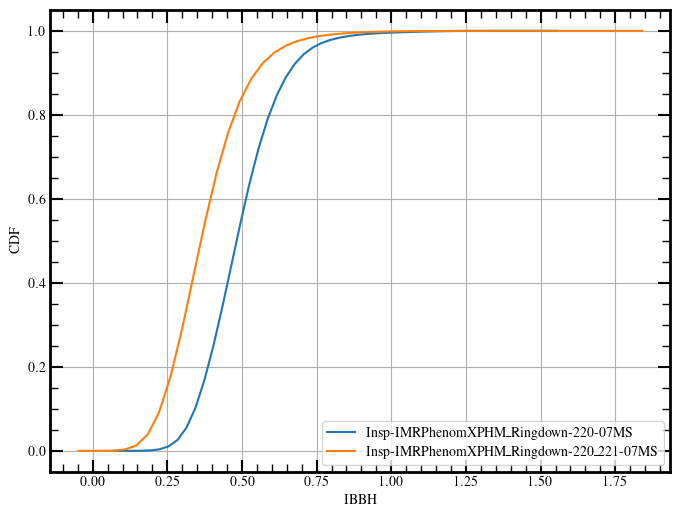

In [55]:
IBBH220 = (1 / 3) * (Ef220 - E1 - E2) / (E1 + E2)
IBBH220221 = (1 / 3) * (Ef220221 - E1 - E2) / (E1 + E2)
binsize = 50
n220, bins220, patches220 = plt.hist(IBBH220.flatten(), bins=binsize, density=True, label="Insp-IMRPhenomXPHM_Ringdown-220-07MS", zorder=2) # more zorder means above
n220221, bins220221, patches220221 = plt.hist(
    IBBH220221.flatten(), bins=binsize, density=True, label="Insp-IMRPhenomXPHM_Ringdown-220_221-07MS", zorder=1
)
plt.xlabel("IBBH")
plt.ylabel("PDF")
plt.title("Histogram")
plt.legend()
plt.show()
pdf220 = n220 / sum(n220)
cdf220 = np.cumsum(pdf220)
bins_central220 = 0.5 * (bins220[1:] + bins220[:-1])

pdf220221 = n220221 / sum(n220221)
cdf220221 = np.cumsum(pdf220221)
bins_central220221 = 0.5 * (bins220221[1:] + bins220221[:-1])

plt.plot(bins_central220, cdf220, label="Insp-IMRPhenomXPHM_Ringdown-220-07MS")
plt.plot(bins_central220221, cdf220221, label="Insp-IMRPhenomXPHM_Ringdown-220_221-07MS")
plt.xlabel("IBBH")
plt.ylabel("CDF")
plt.legend()
plt.grid()
plt.show()


In [56]:
print("Percentage of negative IBBH 220_221", np.sum(IBBH220221<0)/np.size(IBBH220221)*100)
print("Percentage of negative IBBH 220", np.sum(IBBH220<0)/np.size(IBBH220221)*100)
print("Percentage of IBBH 220_221>1 ", np.sum(IBBH220221>1)/np.size(IBBH220221)*100)
print("Percentage of IBBH 220>1 ", np.sum(IBBH220>1)/np.size(IBBH220221)*100)

Percentage of negative IBBH 220_221 0.0008107932246111274
Percentage of negative IBBH 220 0.0
Percentage of IBBH 220_221>1  0.16571260762060014
Percentage of IBBH 220>1  0.3989368077863547


In [57]:
def brahma(rho, limit, modes):
    # mode should be string 220 or 220_221
    """rho = Percentage of fail to be dropped off; limit = Theoretical limit, uniform prior, astrophysical prior"""
    if modes == "220":
        IBBH = (1 / 3) * (Ef220 - E1 - E2) / (E1 + E2)
    elif modes == "220_221":
        IBBH = (1 / 3) * (Ef220221 - E1 - E2) / (E1 + E2)
    # print("Minimum value in IBBH is ", np.min(IBBH))
    # print("Maximum value in IBBH is ", np.max(IBBH))
    # print("Shape of IBBH is ", IBBH.shape)
    # print("Sum of values > 1 of IBBH ", np.sum(IBBH > limit))
    # print("Sum of values < 0 of IBBH ", np.sum(IBBH < 0))
    # print(
    #     "Percentage of IBBH to be removed ",
    #     ((np.sum(IBBH > limit) + np.sum(IBBH < 0)) / (IBBH.shape[0] * IBBH.shape[1])) * 100,
    # )

    columns = np.array([])
    for i in range(IBBH.shape[1]):
        if (np.sum(IBBH[:, i] > limit) >= 1 or np.sum(IBBH[:, i] < 0) >= 1):
            fail = 100 * (np.sum(IBBH[:, i] > limit) + np.sum(IBBH[:, i] < 0)) / IBBH.shape[0]
            # print("Column number number ", i, " percentage of Fail values ", fail)
            if fail >= rho:
                columns = np.append(columns, int(i))
                # IBBH_new = np.delete(IBBH, i, axis=1)


    rows = np.array([])
    for i in range(IBBH.shape[0]):
        if (np.sum(IBBH[i, :] > limit) >= 1 or np.sum(IBBH[i, :] < 0) >=1):
            fail = 100 * (np.sum(IBBH[i, :] > limit) + np.sum(IBBH[i, :] < 0)) / IBBH.shape[1]
            # print("Row number ", i, " percentage of Fail values ", fail)
            if fail >= rho:
                rows = np.append(rows, int(i))
                # IBBH_new = np.delete(IBBH, i, axis=0)
    rows = rows.astype(np.int64) # represents rows numbers to be deleted
    columns = columns.astype(np.int64) # represents columns numbers to be deleted
    # print("Row numbers ", rows)
    # print("Column numbers ", columns)
    
    if limit > 1:  # so that original samples remain same after applying np.delete to delete rows/columns
        rows = [] # nothing will get deleted
        columns = []

    return rows, columns


For n:  2.0
For Ringdown mode  220
[]


/tmp/ipykernel_35870/1847667476.py:68: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(xx, yy, f, s, colors="k")


For Ringdown mode  220_221
[]
-1.2350961614834035 1.368030828034812
For n:  1.0
For Ringdown mode  220
[ 120  121  165  183  184  185  186  541  803 1291]
For Ringdown mode  220_221
[120 121 165 185 186 541]
For n:  0.5
For Ringdown mode  220
[   0    1    2 ... 1397 1398 1399]
For Ringdown mode  220_221
[   1    2    3    4   12   13   25   26   30   33   44   46   47   51
   52   53   54   55   56   57   66   67   76   77   78   79   80   81
   82   84   85   86   87   88   89   91   93   94   95   96   97   99
  100  103  104  105  106  110  111  117  118  119  120  121  122  123
  124  125  126  127  128  129  130  131  133  134  136  137  147  148
  149  150  151  152  162  163  165  168  169  170  171  175  176  177
  178  180  182  183  184  185  186  187  188  193  194  195  196  198
  200  203  208  209  211  212  213  214  215  221  222  224  234  238
  240  241  245  246  247  250  251  254  255  257  259  273  274  275
  277  279  280  281  282  283  287  288  289  290  291

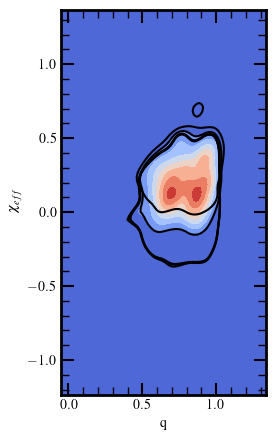

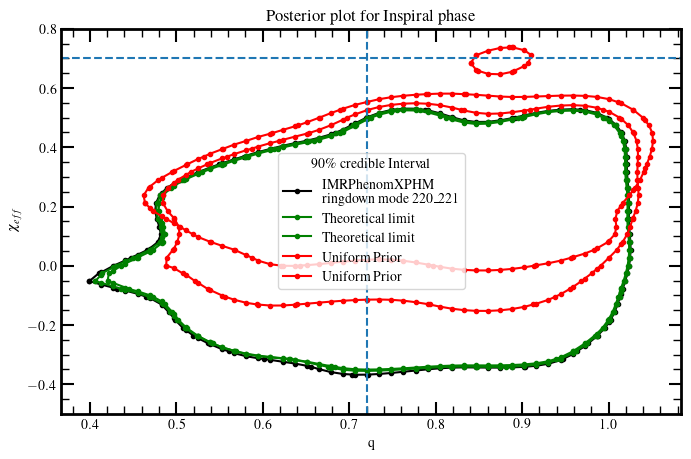

In [62]:
fp = inference.io.loadfile("inference_gw190521_IMRPhenom_chieff_q.hdf", "r")
samples = fp.read_samples(fp["samples"].keys(), temps=0)
n = np.array(
    [2,1,0.5]
)  # Theoretical limit, uniform prior, astrophysical prior, Anything greater than 1 means original samples i.r. rows = []
# Removing rows which fail the BRAHMA ramework test
modes = ['220','220_221']
for limit in n:
    print("For n: ", limit)
    for mode in modes:
        print("For Ringdown mode ", mode)
        rows, columns = brahma(rho=10, limit=limit, modes = mode) # row and columns numbers to be deleted
        # if mode == "220":
        #     samples = fp220.read_samples(fp220["samples"].keys(), temps=0)

        # if mode == "220_221":
        #     samples = fp220221.read_samples(fp220221["samples"].keys(), temps=0)
        print(rows)
        chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
        q = np.delete(samples["q"], rows, axis=0)
        loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)

        # print(columns)
        # final_spin = np.delete(samples["final_spin"], columns, axis=0)
        # final_mass = np.delete(samples["final_mass"], columns, axis=0)
        # loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
        # x = final_mass
        # y = final_spin

        # Extract x and y
        x = q
        y = chi_eff

        if limit > 1 and mode == '220_221': # 
            deltaX = (max(x) - min(x)) / 2
            deltaY = (max(y) - min(y)) / 2
            xmin = min(x)  - deltaX
            xmax = max(x)  + deltaX
            ymin = min(y)  - deltaY
            ymax = max(y)  + deltaY
            print(ymin, ymax)
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

            fig = plt.figure(figsize=(8, 5))
            ax = fig.gca()
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)

        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        if values.shape[1] == 0:
            continue
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        cfset1 = ax.contourf(xx, yy, f, cmap="coolwarm")

        percentiles = np.array([90.0])
        percentiles = 100.0 - np.array(percentiles)
        percentiles.sort()

        draw = kernel.resample
        resamps = kernel(draw(int(100**2)))
        s = np.percentile(resamps, percentiles)

        ax.imshow(np.rot90(f), cmap="coolwarm", extent=[xmin, xmax, ymin, ymax])

        cset = ax.contour(xx, yy, f, s, colors="k")

        # lbls = ["{p}%".format(p=int(p)) for p in (100.0 - percentiles)]
        # fmt = dict(zip(cset.levels, lbls))

        # ax.clabel(cset, cset.levels, inline=True, fmt=fmt, fontsize=10)
        if limit > 1 and mode == '220_221': #
            plt.figure(figsize=(8, 5))
        text = ["IMRPhenomXPHM", "Theoretical limit", "Uniform Prior", "Astrophysical Prior"]
        colors = ["k", "g", "r"]
        for j in range(len(cset.allsegs)):
            for ii, seg in enumerate(cset.allsegs[j]):
                if ii == 0:
                    if limit>1:
                        plt.plot(seg[:, 0], seg[:, 1], ".-", color = colors[np.where(n == limit)[0][0]],
                         label=text[np.where(n == limit)[0][0]]+"\n ringdown mode " + str(mode))
                    else:
                        plt.plot(seg[:, 0], seg[:, 1], ".-", color = colors[np.where(n == limit)[0][0]], label=text[np.where(n == limit)[0][0]])
                else:
                    plt.plot(seg[:, 0], seg[:, 1], ".-", color = colors[np.where(n == limit)[0][0]])

ax.set_xlabel("q")
ax.set_ylabel("$\chi_{eff}$")
plt.title("Posterior plot for Inspiral phase ")
plt.ylim(-0.5, 0.8)
plt.xlabel("q")
plt.ylabel("$\chi_{eff}$")
plt.legend(title='90$\%$ credible Interval')
plt.axvline(0.72,linestyle = '--')
plt.axhline(0.7,linestyle = '--')
# plt.savefig("Inspiral220-07MS_IMRPhenom.pdf", format="pdf", bbox_inches="tight")


# ax.set_xlabel("$M_f$")
# ax.set_ylabel("$\chi_{f}$")
# plt.title("Posterior plot for Ringdown phase")

# plt.xlabel("$M_f$")
# plt.ylabel("$\chi_{f}$")
# plt.legend(title='90$\%$ credible Interval')

# plt.axvline(254.31,linestyle = '--')
# plt.axhline(0.72,linestyle = '--')
# plt.savefig("Ringdown220-221-07MS_IMRPhenom.pdf", format="pdf", bbox_inches="tight")
plt.show()


For n:  2.0
For Ringdown mode  220_221
[]
-0.43307767895478566 1.4640169107260048
For n:  1.0
For Ringdown mode  220_221
[  211   658  2750  3644  4025  4218  4438  5457  6989  7296  8529 11512
 12128 12306 13454 15451 17652 18668 19861 22159 22775 23515 24085 24462
 25356 25870 27373 28548 29269 32495 32857 33037 35877 38881 39929 41769
 41885 42258 42386 42815 43353 47582 47667 47745 47856 48476 48743 49095
 49714 51233 51873 52836 53002 53770 54365 54701 55441 56292 56484 56680
 57358 57458 59057 59484 61566 61796 62984 63071 63195 64096 64128 66729
 66906 67126 67309 68169 71742 73854 74520 74910 76257 78145 78571 78601
 80973 81585 81743 81965 82704 82742]
For n:  0.5
For Ringdown mode  220_221
[    0     2     3 ... 83423 83425 83426]


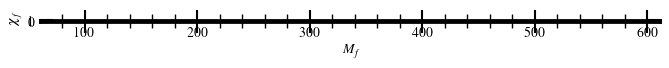

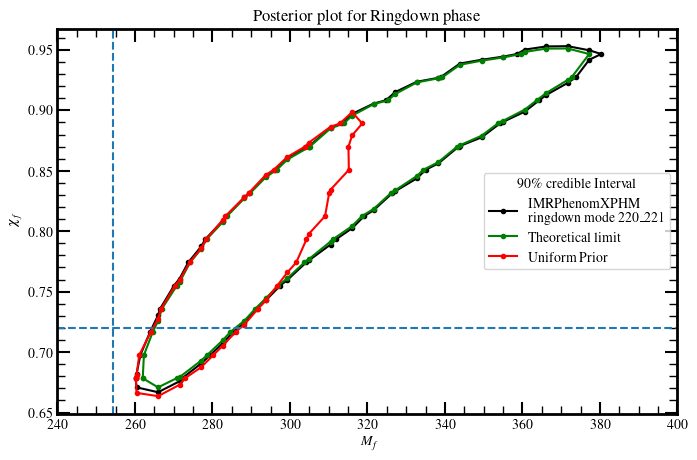

In [61]:
# fp = inference.io.loadfile("inference_gw190521_IMRPhenom_chieff_q.hdf", "r")
# samples = fp.read_samples(fp["samples"].keys(), temps=0)
n = np.array(
    [2,1,0.5]
)  # Theoretical limit, uniform prior, astrophysical prior, Anything greater than 1 means original samples i.r. rows = []
# Removing rows which fail the BRAHMA ramework test
modes = ['220','220_221']
for limit in n:
    print("For n: ", limit)
    for mode in modes:
        print("For Ringdown mode ", mode)
        rows, columns = brahma(rho=10, limit=limit, modes = mode) # row and columns numbers to be deleted
        if mode == "220":
            samples = fp220.read_samples(fp220["samples"].keys(), temps=0)

        if mode == "220_221":
            samples = fp220221.read_samples(fp220221["samples"].keys(), temps=0)
        # print(rows)
        # chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
        # q = np.delete(samples["q"], rows, axis=0)
        # loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)

        print(columns)
        final_spin = np.delete(samples["final_spin"], columns, axis=0)
        final_mass = np.delete(samples["final_mass"], columns, axis=0)
        loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
        x = final_mass
        y = final_spin

        # Extract x and y
        # x = q
        # y = chi_eff

        if limit > 1 and mode == '220_221': # 
            deltaX = (max(x) - min(x)) / 2
            deltaY = (max(y) - min(y)) / 2
            xmin = min(x)  - deltaX
            xmax = max(x)  + deltaX
            ymin = min(y)  - deltaY
            ymax = max(y)  + deltaY
            print(ymin, ymax)
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

            fig = plt.figure(figsize=(8, 5))
            ax = fig.gca()
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)

        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        if values.shape[1] == 0:
            continue
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        cfset1 = ax.contourf(xx, yy, f, cmap="coolwarm")

        percentiles = np.array([90.0])
        percentiles = 100.0 - np.array(percentiles)
        percentiles.sort()

        draw = kernel.resample
        resamps = kernel(draw(int(100**2)))
        s = np.percentile(resamps, percentiles)

        ax.imshow(np.rot90(f), cmap="coolwarm", extent=[xmin, xmax, ymin, ymax])

        cset = ax.contour(xx, yy, f, s, colors="k")

        # lbls = ["{p}%".format(p=int(p)) for p in (100.0 - percentiles)]
        # fmt = dict(zip(cset.levels, lbls))

        # ax.clabel(cset, cset.levels, inline=True, fmt=fmt, fontsize=10)
        if limit > 1 and mode == '220_221': #
            plt.figure(figsize=(8, 5))
        text = ["IMRPhenomXPHM", "Theoretical limit", "Uniform Prior", "Astrophysical Prior"]
        colors = ["k", "g", "r"]
        for j in range(len(cset.allsegs)):
            for ii, seg in enumerate(cset.allsegs[j]):
                if ii == 0:
                    if limit>1:
                        plt.plot(seg[:, 0], seg[:, 1], ".-", color = colors[np.where(n == limit)[0][0]],
                         label=text[np.where(n == limit)[0][0]]+"\n ringdown mode " + str(mode))
                    else:
                        plt.plot(seg[:, 0], seg[:, 1], ".-", color = colors[np.where(n == limit)[0][0]], label=text[np.where(n == limit)[0][0]])
                else:
                    plt.plot(seg[:, 0], seg[:, 1], ".-", color = colors[np.where(n == limit)[0][0]])

# ax.set_xlabel("q")
# ax.set_ylabel("$\chi_{eff}$")
# plt.title("Posterior plot for Inspiral phase ")
# plt.ylim(-0.5, 0.8)
# plt.xlabel("q")
# plt.ylabel("$\chi_{eff}$")
# plt.legend(title='90$\%$ credible Interval')
# plt.axvline(0.72,linestyle = '--')
# plt.axhline(0.7,linestyle = '--')
# plt.savefig("Inspiral220-07MS_IMRPhenom.pdf", format="pdf", bbox_inches="tight")


ax.set_xlabel("$M_f$")
ax.set_ylabel("$\chi_{f}$")
plt.title("Posterior plot for Ringdown phase")

plt.xlabel("$M_f$")
plt.ylabel("$\chi_{f}$")
plt.legend(title='90$\%$ credible Interval')
plt.xlim(240,400)
plt.axvline(254.31,linestyle = '--')
plt.axhline(0.72,linestyle = '--')
# plt.savefig("Ringdown220-221-07MS_IMRPhenom.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
import p

samples = fp.read_samples(fp["samples"].keys(), temps=0)
parameters = ["q", "chi_eff"]

print("Shape before removing ", samples["q"].shape)
# Removing rows which fail the BRAHMA framework
chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
q = np.delete(samples["q"], rows, axis=0)
loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)
dic = {"chi_eff": chi_eff, "q": q, "loglikelihood": loglikelihood}


print("Shape after removing ", q.shape)  # Original - 90 credible interval - IBBH limit

fig, axis_dict = p.create_multidim_plot(
    parameters,
    dic,
    labels=None,
    mins=None,
    maxs=None,
    expected_parameters=None,
    expected_parameters_color="r",
    plot_marginal=True,
    plot_scatter=False,
    plot_maxl=False,
    plot_marginal_lines=True,
    marginal_percentiles=None,
    contour_percentiles=None,
    marginal_title=True,
    marginal_linestyle="-",
    zvals=None,
    show_colorbar=True,
    cbar_label=None,
    vmin=None,
    vmax=None,
    scatter_cmap="plasma",
    plot_density=True,
    plot_contours=True,
    density_cmap="viridis",
    contour_color=None,
    label_contours=True,
    contour_linestyles=None,
    hist_color="black",
    line_color=None,
    fill_color="gray",
    use_kombine=False,
    kdeargs=None,
    fig=None,
    axis_dict=None,
)
fig, axis_dict = p.create_multidim_plot(
    parameters,
    samples,
    labels=None,
    mins=None,
    maxs=None,
    expected_parameters=None,
    expected_parameters_color="r",
    plot_marginal=True,
    plot_scatter=False,
    plot_maxl=False,
    plot_marginal_lines=True,
    marginal_percentiles=None,
    contour_percentiles=None,
    marginal_title=True,
    marginal_linestyle="-",
    zvals=None,
    show_colorbar=True,
    cbar_label=None,
    vmin=None,
    vmax=None,
    scatter_cmap="plasma",
    plot_density=True,
    plot_contours=True,
    density_cmap="viridis",
    contour_color=None,
    label_contours=True,
    contour_linestyles=None,
    hist_color="black",
    line_color=None,
    fill_color="gray",
    use_kombine=False,
    kdeargs=None,
    fig=None,
    axis_dict=None,
)


OSError: [Errno 5] Can't read data (file read failed: time = Mon Sep 12 08:31:42 2022
, filename = 'inference_gw190521_chieff_q.hdf', file descriptor = 79, errno = 5, error message = 'Input/output error', buf = 0x56306137a350, total read size = 20004, bytes this sub-read = 20004, bytes actually read = 18446744073709551615, offset = 0)

Shape before removing  1600


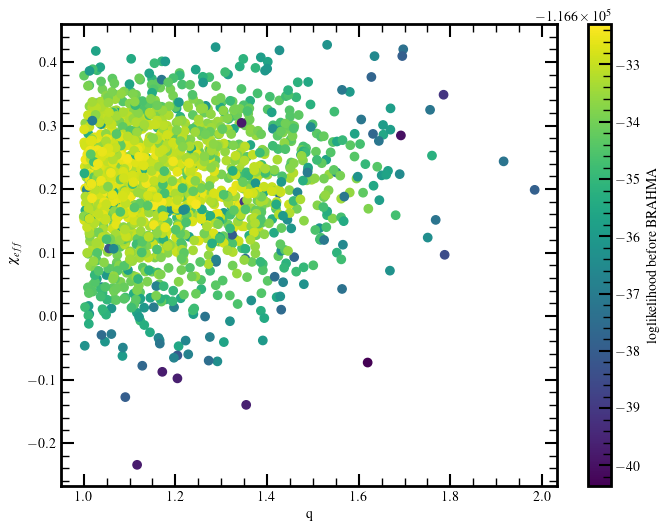

Shape after removing  (1539,)


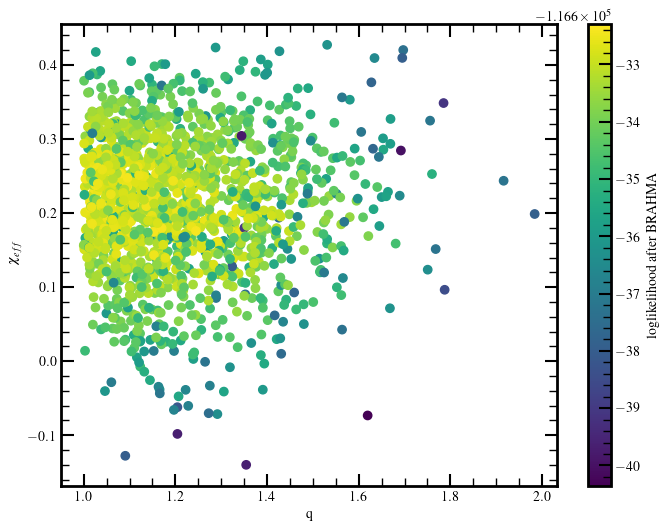

In [ ]:
samples = fp.read_samples(fp["samples"].keys(), temps=0)

loglikelihood = samples["loglikelihood"]
q = samples["q"]
mass1 = samples["mass1"]
chi_eff = samples["chi_eff"]
print("Shape before removing ", len(mass1))

plt.figure()
plt.scatter(q, chi_eff, c=loglikelihood)
plt.xlabel("q")
plt.ylabel("$\chi_{eff}$")
cbar1 = plt.colorbar()
cbar1.set_label("loglikelihood before BRAHMA")
plt.show()


chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
q = np.delete(samples["q"], rows, axis=0)
loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)
print("Shape after removing ", q.shape)  # Original - 90 credible interval - IBBH limit

plt.figure()
plt.scatter(q, chi_eff, c=loglikelihood)
plt.xlabel("q")
plt.ylabel("$\chi_{eff}$")
cbar2 = plt.colorbar()
cbar2.set_label("loglikelihood after BRAHMA")
plt.show()


In [ ]:
IBBH = (1 / 3) * (Ef - E1 - E2) / (E1 + E2)
rho = 10  # Percentage of fail to be dropped off
limit = 0.5  # Theoretical limit, uniform prior, astrophysical prior

print("Minimum value in IBBH is ", np.min(IBBH))
print("Maximum value in IBBH is ", np.max(IBBH))
print("Shape of IBBH is ", IBBH.shape)
print("Sum of values > 1 of IBBH ", np.sum(IBBH > limit))
print("Sum of values < 0 of IBBH ", np.sum(IBBH < 0))
print(
    "Percentage of IBBH to be removed ",
    (1 - (IBBH.shape[0] * IBBH.shape[1] - (np.sum(IBBH > limit) + np.sum(IBBH < 0))) / (IBBH.shape[0] * IBBH.shape[1]))
    * 100,
)


columns = np.array([])
for i in range(IBBH.shape[1]):
    if np.sum(IBBH[:, i] > limit) >= 1:
        fail = 100 * np.sum(IBBH[:, i] > limit) / IBBH.shape[0]
        # print("Column number number ", i, " percentage of Fail values ", fail)
        if fail >= rho:
            columns = np.append(columns, int(i))
            # IBBH_new = np.delete(IBBH, i, axis=1)
columns = columns.astype(np.int64)
print("Column numbers ", columns)


Minimum value in IBBH is  -0.010585854412618395
Maximum value in IBBH is  0.9443399872655028
Shape of IBBH is  (1770, 85996)
Sum of values > 1 of IBBH  3081950
Sum of values < 0 of IBBH  2
Percentage of IBBH to be removed  2.024763732277124
Column numbers  [   17   251   458   587   669  1013  1543  2075  2101  2398  2551  2802
  3127  3157  3273  3344  3386  3395  3482  3781  4010  4059  4115  4465
  4756  4818  5141  5169  5368  5412  5480  5623  5912  5926  6090  6297
  6341  6505  6736  6952  7007  7449  7511  7545  7686  7800  7929  7964
  8436  8571  8857  8993  9169  9335  9482  9600  9635  9852 10051 10131
 10221 10293 10568 10679 10805 11093 11283 11447 11451 12088 12239 12611
 12728 12813 13011 13377 13689 13726 13812 14437 14662 14729 14821 14884
 14962 15089 15721 15772 15809 15879 15948 15953 16011 16147 16231 16359
 16841 17043 17254 17389 17449 17571 17608 17690 17794 17836 17945 17991
 18075 18132 18322 18543 18570 18750 18928 19106 19161 19192 19279 19285
 19340 19465 

In [ ]:
fpr["samples"].keys()


<KeysViewHDF5 ['amp220', 'amp221', 'f220', 'f221', 'final_mass', 'final_spin', 'inclination', 'logamp220', 'loglikelihood', 'loglikelihood220', 'loglikelihood221', 'lognl', 'logwt', 'phi220', 'phi221', 'polarization', 'tau220', 'tau221']>

Shape before removing  95552
Shape after removing  94931


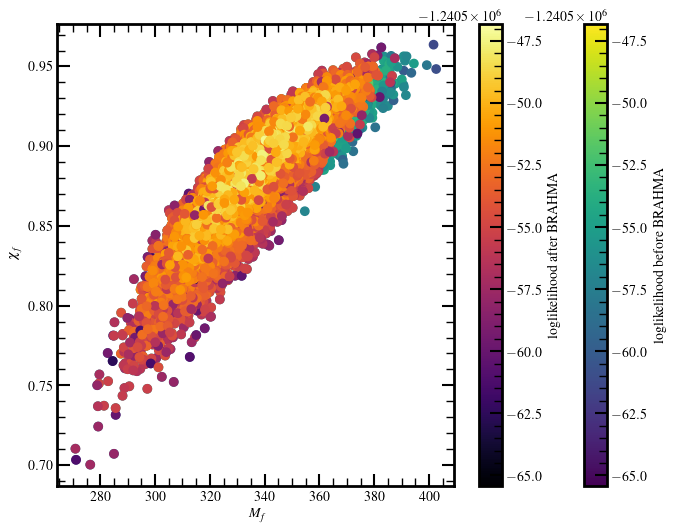

In [ ]:
samples = fpr.read_samples(fpr["samples"].keys(), temps=0)

loglikelihood = samples["loglikelihood"]
final_mass = samples["final_mass"]
final_spin = samples["final_spin"]
print("Shape before removing ", len(final_mass))

plt.scatter(final_mass, final_spin, c=loglikelihood)
cbar1 = plt.colorbar()
cbar1.set_label("loglikelihood before BRAHMA")


final_spin = np.delete(samples["final_spin"], columns, axis=0)
final_mass = np.delete(samples["final_mass"], columns, axis=0)
loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
print("Shape after removing ", len(final_mass))  # Original - 90 credible interval - IBBH limit


plt.scatter(final_mass, final_spin, c=loglikelihood, cmap="inferno")
plt.xlabel("$M_f$")
plt.ylabel("$\chi_{f}$")
cbar1 = plt.colorbar()
cbar1.set_label("loglikelihood after BRAHMA")

plt.show()


# Entropies E1 and E2

In [42]:
E1 = (mass1**2) * (
    1 + np.sqrt(1 - np.abs(spin1z) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
mass2 = mass1 / q
spin2z = chi_eff * (1 + q) - q*spin1z
print("Limit of spin2z is ", np.min(spin2z), np.max(spin2z))
E2 = (mass2**2) * (1 + np.sqrt(1 - np.abs(spin2z) ** 2))  # Initial Entropy of BH2


Limit of spin2z is  -0.9947591262415341 0.9931258364555976


# Removing unphysical spin2z and corresponding spin1z, mass1, mass2

In [43]:
# # Run it only once
# mass1 = mass1[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# spin1z = spin1z[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# q = q[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# chi_eff = chi_eff[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# mass2 = mass2[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# loglikelihood = loglikelihood[np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))]
# spin2z = spin2z[
#     np.intersect1d(np.where(spin2z < 1), np.where(spin2z > -1))
# ]  # Note: keep this at end otherwise spin2z would change
# mass1.shape


In [44]:
# E1 = (mass1**2) * (
#     1 + np.sqrt(1 - np.abs(spin1z) ** 2)
# )  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
# mass2 = q * mass1
# spin2z = (chi_eff * (1 + q) - spin1z) / q
# E2 = (mass2**2) * (1 + np.sqrt(1 - np.abs(spin2z) ** 2))  # Initial Entropy of BH2


# Extracting 90/% credible interval

In [45]:
# # Run it only once
# binsize = 50
# n, bins, patches = plt.hist(loglikelihood, bins=binsize, density=True)

# print("Length before removing ", len(loglikelihood))
# plt.ylabel("PDF")
# plt.xlabel("loglikelihood")
# plt.title("likelihood histogram")
# plt.show()

# lower = np.percentile(loglikelihood, 50 - 90 / 2)
# upper = np.percentile(loglikelihood, 50 + 90 / 2)
# loglikelihood = loglikelihood[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# q = q[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# chi_eff = chi_eff[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# mass1 = mass1[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# spin1z = spin1z[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]

# samples = samples[np.intersect1d(np.where(loglikelihood < upper), np.where(loglikelihood > lower))]
# print("Samples of 90 \%credible region ", samples)
# print("Length after removing ", len(loglikelihood))

# n, bins, patches = plt.hist(loglikelihood, bins=binsize, density=True)
# plt.title("likelihood histogram 90% credible interval")
# plt.ylabel("PDF")
# plt.xlabel("loglikelihood")
# plt.show()


In [46]:
# plt.scatter(q, chi_eff, c=loglikelihood)
# plt.xlabel("q")
# plt.ylabel("$\chi_{eff}$")
# cbar = plt.colorbar()
# cbar.set_label("loglikelihood")
# plt.show()


# Ringdown

In [47]:
for model_name in models.models:
    print(model_name)


test_eggbox
test_normal
test_rosenbrock
test_volcano
test_posterior
test_prior
gaussian_noise
marginalized_phase
marginalized_polarization
marginalized_hmpolphase
brute_parallel_gaussian_marginalize
gated_gaussian_noise
gated_gaussian_margpol
single_template
relative
hierarchical
multi_signal


To do a BH ringdown analysis we need to use one of the gated Gaussian models. Note that there are two: the standard `gated_gaussian_noise` model, and a `gated_gaussian_margpol`. The latter does the same thing, it just marginalizes over the polarization angle numerically to speed up convergence. We'll use that model here

In [48]:
model_config_ringdown = """
[model]
name = gated_gaussian_margpol
low-frequency-cutoff = 15
"""


In [49]:
!echo '{model_config_ringdown}' > model_GW190521_ringdown.ini
!cat model_GW190521_ringdown.ini


[model]
name = gated_gaussian_margpol
low-frequency-cutoff = 15



In [50]:
c = Catalog("gwtc-2")
data_config_ringdown = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -4
analysis-end-time = 4
data-conditioning-low-freq = H1:0 L1:0 V1:0
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN
sample-rate = 2048
strain-high-pass = 15
pad-data = 8
""".format(event_tc=c["GW190521-v3"].time, h1file=fname["H1"], l1file=fname["L1"], v1file=fname["V1"])


In [51]:
!echo '{data_config_ringdown}' > data_GW190521_ringdown.ini
!cat data_GW190521_ringdown.ini


[data]
instruments = H1 L1 V1
trigger-time = 1242442967.4
analysis-start-time = -4
analysis-end-time = 4
data-conditioning-low-freq = H1:0 L1:0 V1:0
psd-estimation = median-mean
psd-start-time = -256
psd-end-time = 256
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
frame-files = H1:/home/ash/.astropy/cache/download/url/12f80ba4df74fc6ea7281d6b9ec65878/contents L1:/home/ash/.astropy/cache/download/url/995f03271fdfc6a332432bf811edf3c6/contents V1:/home/ash/.astropy/cache/download/url/2a626694bbb8142baf12489ab93fc7c5/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN
sample-rate = 2048
strain-high-pass = 15
pad-data = 8



In [52]:
HTML("posterior_summary.html")


In [53]:
prior_config_ringdown = """
[static_params]
approximant = TdQNMfromFinalMassSpin
harmonics = spheroidal
tref = ${data|trigger-time}
ra = 3.5
dec = 0.73
toffset = 0.018
; time after merger when ringown (linear regime) starts
lmns = 222
t_final = 2 

[variable_params]
; ref_amp (str, optional) - Which mode to use as the reference for computing amplitudes
final_mass = 
final_spin = 
inclination = 
logamp220 = 
; if ref_amp = 'amp220', lmns = ['221', '331'], and no distance is provided, then amp220 = 1e-22, amp330 = 0.1 would result in the 220 mode
;  having a strain amplitude of 1e-22 and the 330 mode having a strain amplitude of 1e-23.
phi220 =
amp221 =
phi221 =

[waveform_transforms-t_gate_end]
name = custom
inputs = tref
t_gate_end = tref + 0.0

[waveform_transforms-t_gate_start]
name = custom
inputs = t_gate_end
t_gate_start = t_gate_end - 2

[waveform_transforms-tc]
name = custom
inputs = t_gate_end
tc = t_gate_end - 0.001

[prior-final_mass]
name = uniform
min-final_mass = 100
max-final_mass = 500

[prior-final_spin]
name = uniform
min-final_spin = -0.99
max-final_spin = 0.99

[prior-inclination]
name = sin_angle

[prior-logamp220]
name = uniform
min-logamp220 = -24
max-logamp220 = -19

[waveform_transforms-amp220]
name = custom
inputs = logamp220
amp220 = 10**logamp220

[prior-phi220]
name = uniform_angle

[prior-amp221]
name = uniform
min-amp221 = 0
max-amp221 = 5

[prior-phi221]
name = uniform_angle
"""


In [54]:
!echo '{prior_config_ringdown}' > prior_GW190521_ringdown.ini
!cat prior_GW190521_ringdown.ini


[static_params]
approximant = TdQNMfromFinalMassSpin
harmonics = spheroidal
tref = ${data|trigger-time}
ra = 3.5
dec = 0.73
toffset = 0.018
; time after merger when ringown (linear regime) starts
lmns = 222
t_final = 2 

[variable_params]
; ref_amp (str, optional) - Which mode to use as the reference for computing amplitudes
final_mass = 
final_spin = 
inclination = 
logamp220 = 
; if ref_amp = amp220, lmns = [221, 331], and no distance is provided, then amp220 = 1e-22, amp330 = 0.1 would result in the 220 mode
;  having a strain amplitude of 1e-22 and the 330 mode having a strain amplitude of 1e-23.
phi220 =
amp221 =
phi221 =

[waveform_transforms-t_gate_end]
name = custom
inputs = tref
t_gate_end = tref + 0.0

[waveform_transforms-t_gate_start]
name = custom
inputs = t_gate_end
t_gate_start = t_gate_end - 2

[waveform_transforms-tc]
name = custom
inputs = t_gate_end
tc = t_gate_end - 0.001

[prior-final_mass]
name = uniform
min-final_mass = 100
max-final_mass = 500

[prior-final_spi

In [55]:
!wget https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf 

--2022-09-12 08:27:26--  https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf [following]
--2022-09-12 08:27:27--  https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8562013 (8.2M) [application/octet-stream]
Saving to: ‘KERR-220-07MS.hdf.2’

KERR-220-07MS.hdf.2 100%[===================>]   8.17M  2.70MB/s   

In [56]:
!pycbc_inference_plot_posterior --verbose \
    --input-file KERR-220-07MS.hdf  \
    --output-file completed_scatter.png \
    --plot-scatter --plot-marginal \
    --z-arg loglikelihood

2022-09-12 08:27:38,103 Reading input file KERR-220-07MS.hdf
2022-09-12 08:27:38,105 Loading samples
2022-09-12 08:27:38,186 Loaded 70402 samples
2022-09-12 08:27:38,186 Getting samples for colorbar
2022-09-12 08:27:38,194 Plotting
2022-09-12 08:27:49,973 Done


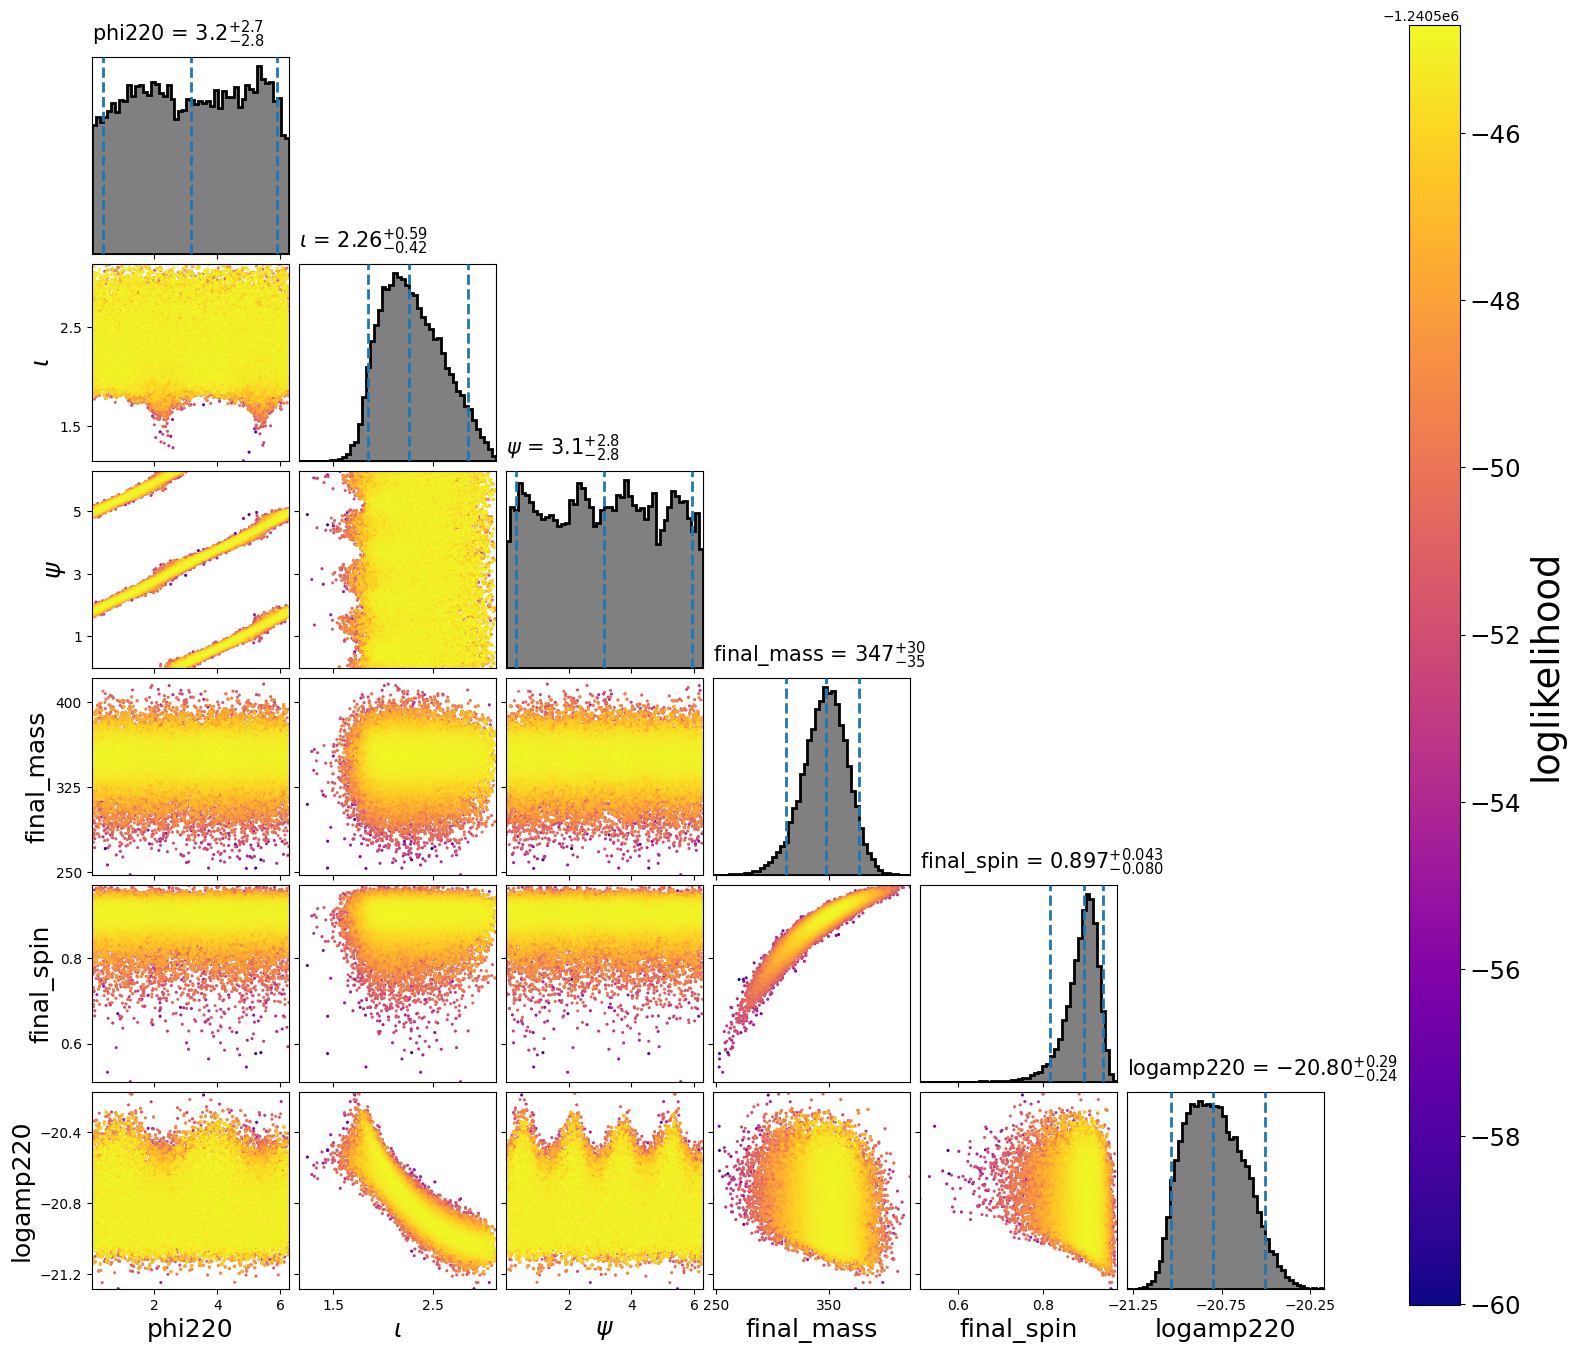

In [57]:
Image("completed_scatter.png", height=480)


In [58]:
!wget https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf 

--2022-09-12 08:27:51--  https://github.com/gwastro/BH-Spectroscopy-GW190521/raw/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf [following]
--2022-09-12 08:27:52--  https://raw.githubusercontent.com/gwastro/BH-Spectroscopy-GW190521/main/posteriors/kerr/220/KERR-220-07MS.hdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8562013 (8.2M) [application/octet-stream]
Saving to: ‘KERR-220-07MS.hdf.3’

KERR-220-07MS.hdf.3 100%[===================>]   8.17M  2.91MB/s   

In [59]:
!pycbc_inference_plot_posterior --help

usage: pycbc_inference_plot_posterior [-h] [--input-file FILE[:LABEL]
                                      [FILE[:LABEL] ...]] [-H]
                                      [--parameters PARAM[:LABEL]
                                      [PARAM[:LABEL] ...]]
                                      [--constraint CONSTRAINT[:FILE]
                                      [CONSTRAINT[:FILE] ...]] [--version]
                                      [--output-file OUTPUT_FILE] [--verbose]
                                      [--plot-prior PLOT_PRIOR [PLOT_PRIOR ...]]
                                      [--prior-nsamples PRIOR_NSAMPLES]
                                      [--plot-marginal]
                                      [--marginal-percentiles MARGINAL_PERCENTILES [MARGINAL_PERCENTILES ...]]
                                      [--no-marginal-lines]
                                      [--no-marginal-titles] [--plot-scatter]
                                      [--plot-density] [--plo

In [60]:
!pycbc_inference_plot_posterior --verbose \
    --input-file KERR-220-07MS.hdf  KERR-220_221-07MS.hdf \
    --output-file completed_density-mass_spinKERR-220-07MS.png \
    --plot-contours --plot-marginal \
    --density-cmap inferno --contour-colors white \
    --max-kde-samples 5000 \
    --legend-location 'lower right'\
    --parameters \
        'final_mass:$M_f (M_\odot)$' \
        'final_spin:$\chi_f$' --expected-parameters 'final_mass:254.31' 'final_spin:0.72'

2022-09-12 08:28:07,207 Reading input file KERR-220-07MS.hdf
2022-09-12 08:28:07,208 Loading samples
2022-09-12 08:28:07,218 Loaded 70402 samples
2022-09-12 08:28:07,218 Reading input file KERR-220_221-07MS.hdf
2022-09-12 08:28:07,220 Loading samples
2022-09-12 08:28:07,284 Loaded 83428 samples
2022-09-12 08:28:07,285 Plotting
2022-09-12 08:28:17,467 Done


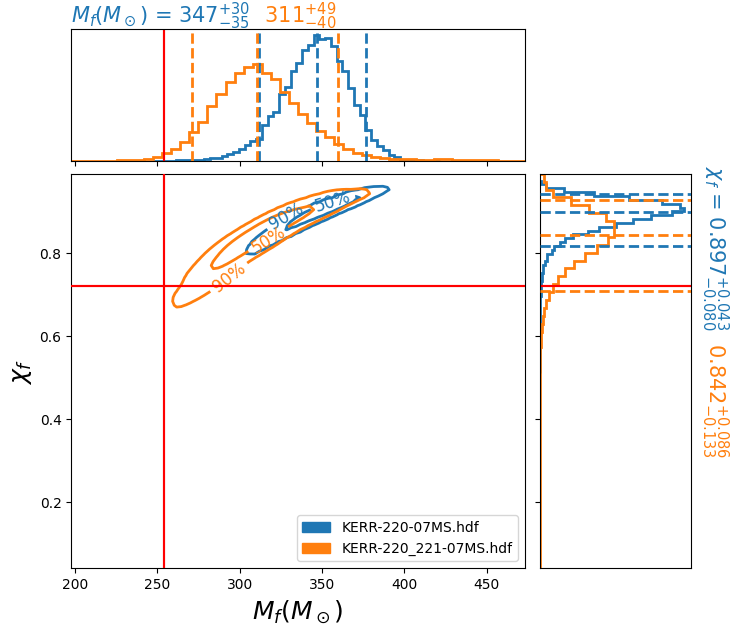

In [61]:
Image("completed_density-mass_spinKERR-220-07MS.png", height=480)


# Depends on tref i.e. starting time of Ringdown

# IO read of Ringdown

In [62]:
fp220221 = inference.io.loadfile("KERR-220_221-07MS.hdf", "r")
fp220 = inference.io.loadfile("KERR-220-07MS.hdf", "r")


In [63]:
samplesr = fp220.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
print(samplesr)

loglikelihood = samplesr["loglikelihood"]
final_mass = samplesr["final_mass"]
final_spin = samplesr["final_spin"]

print("Length ", len(loglikelihood))


[(0.84537615, -1240546.30258507, 326.0285885 )
 (0.87183188, -1240546.84687439, 337.00769959)
 (0.9124024 , -1240545.40375974, 362.65870371) ...
 (0.8957326 , -1240545.41318306, 343.8156648 )
 (0.89684892, -1240545.9336518 , 341.62604978)
 (0.90864241, -1240546.61876556, 361.78911151)]
Length  70402


# Final Entropy

In [64]:
samples220 = fp220.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
samples220221 = fp220221.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)


loglikelihood220 = samples220["loglikelihood"]
final_mass220 = samples220["final_mass"]
final_spin220 = samples220["final_spin"]

Ef220 = (final_mass220**2) * (
    1 + np.sqrt(1 - np.abs(final_spin220) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
print(E1.shape, E2.shape, Ef220.shape)
Ef220 = Ef220.reshape(
    1, Ef220.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2
E1 = E1.reshape(E1.shape[0], 1)
E2 = E2.reshape(E2.shape[0], 1)


loglikelihood220221 = samples220221["loglikelihood"]
final_mass220221 = samples220221["final_mass"]
final_spin220221 = samples220221["final_spin"]

Ef220221 = (final_mass220221**2) * (
    1 + np.sqrt(1 - np.abs(final_spin220221) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
print(E1.shape, E2.shape, Ef220221.shape)
Ef220221 = Ef220221.reshape(
    1, Ef220221.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2


(1400,) (1400,) (70402,)
(1400, 1) (1400, 1) (83428,)


# Merger Entropy Index

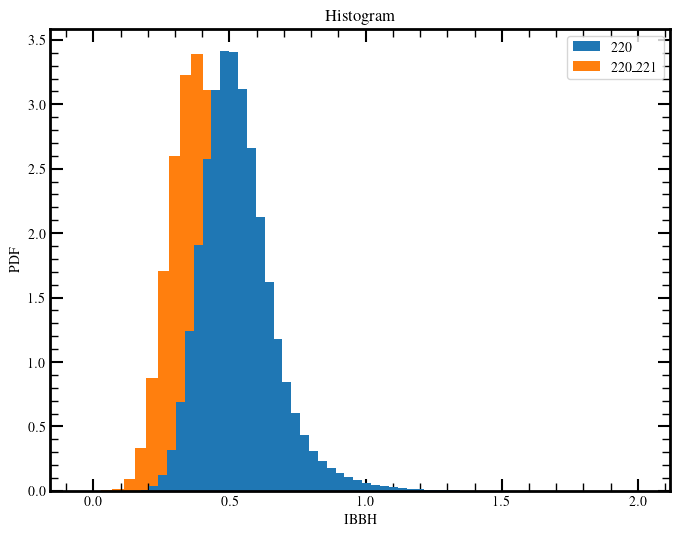

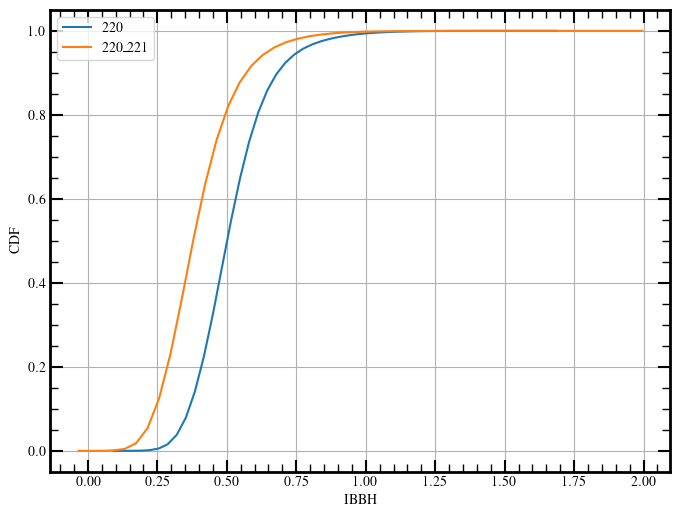

In [65]:
IBBH220 = (1 / 3) * (Ef220 - E1 - E2) / (E1 + E2)
IBBH220221 = (1 / 3) * (Ef220221 - E1 - E2) / (E1 + E2)
binsize = 50
n220, bins220, patches220 = plt.hist(IBBH220.flatten(), bins=binsize, density=True, label="220", zorder=2) # more zorder means above
n220221, bins220221, patches220221 = plt.hist(
    IBBH220221.flatten(), bins=binsize, density=True, label="220_221", zorder=1
)
plt.xlabel("IBBH")
plt.ylabel("PDF")
plt.title("Histogram")
plt.legend()
plt.show()
pdf220 = n220 / sum(n220)
cdf220 = np.cumsum(pdf220)
bins_central220 = 0.5 * (bins220[1:] + bins220[:-1])

pdf220221 = n220221 / sum(n220221)
cdf220221 = np.cumsum(pdf220221)
bins_central220221 = 0.5 * (bins220221[1:] + bins220221[:-1])

plt.plot(bins_central220, cdf220, label="220")
plt.plot(bins_central220221, cdf220221, label="220_221")
plt.xlabel("IBBH")
plt.ylabel("CDF")
plt.legend()
plt.grid()
plt.show()


In [66]:
print("Percentage of negative IBBH 220_221", np.sum(IBBH220221<0)/np.size(IBBH220221)*100)
print("Percentage of negative IBBH 220", np.sum(IBBH220<0)/np.size(IBBH220221)*100)
print("Percentage of IBBH 220_221>1 ", np.sum(IBBH220221>1)/np.size(IBBH220221)*100)
print("Percentage of IBBH 220>1 ", np.sum(IBBH220>1)/np.size(IBBH220221)*100)

Percentage of negative IBBH 220_221 0.00041181788916362443
Percentage of negative IBBH 220 0.0
Percentage of IBBH 220_221>1  0.238517044637292
Percentage of IBBH 220>1  0.6016265522366592


In [67]:
def brahma(rho, limit, modes):
    # mode should be string 220 or 220_221
    """rho = Percentage of fail to be dropped off; limit = Theoretical limit, uniform prior, astrophysical prior"""
    if modes == "220":
        IBBH = (1 / 3) * (Ef220 - E1 - E2) / (E1 + E2)
    elif modes == "220_221":
        IBBH = (1 / 3) * (Ef220221 - E1 - E2) / (E1 + E2)
    # print("Minimum value in IBBH is ", np.min(IBBH))
    # print("Maximum value in IBBH is ", np.max(IBBH))
    # print("Shape of IBBH is ", IBBH.shape)
    # print("Sum of values > 1 of IBBH ", np.sum(IBBH > limit))
    # print("Sum of values < 0 of IBBH ", np.sum(IBBH < 0))
    # print(
    #     "Percentage of IBBH to be removed ",
    #     ((np.sum(IBBH > limit) + np.sum(IBBH < 0)) / (IBBH.shape[0] * IBBH.shape[1])) * 100,
    # )

    columns = np.array([])
    for i in range(IBBH.shape[1]):
        if (np.sum(IBBH[:, i] > limit) >= 1 or np.sum(IBBH[:, i] < 0) >= 1):
            fail = 100 * (np.sum(IBBH[:, i] > limit) + np.sum(IBBH[:, i] < 0)) / IBBH.shape[0]
            # print("Column number number ", i, " percentage of Fail values ", fail)
            if fail >= rho:
                columns = np.append(columns, int(i))
                # IBBH_new = np.delete(IBBH, i, axis=1)


    rows = np.array([])
    for i in range(IBBH.shape[0]):
        if (np.sum(IBBH[i, :] > limit) >= 1 or np.sum(IBBH[i, :] < 0) >=1):
            fail = 100 * (np.sum(IBBH[i, :] > limit) + np.sum(IBBH[i, :] < 0)) / IBBH.shape[1]
            # print("Row number ", i, " percentage of Fail values ", fail)
            if fail >= rho:
                rows = np.append(rows, int(i))
                # IBBH_new = np.delete(IBBH, i, axis=0)
    rows = rows.astype(np.int64) # represents rows numbers to be deleted
    columns = columns.astype(np.int64) # represents columns numbers to be deleted
    # print("Row numbers ", rows)
    # print("Column numbers ", columns)
    
    if limit > 1:  # so that original samples remain same after applying np.delete to delete rows/columns
        rows = [] # nothing will get deleted
        columns = []

    return rows, columns


In [75]:
# fp = inference.io.loadfile("inference_gw190521_chieff_q.hdf", "r")
# samples = fp.read_samples(fp["samples"].keys(), temps=0)
n = np.array(
    [2, 1.0, 0.5]
)  # Theoretical limit, uniform prior, astrophysical prior, Anything greater than 1 means original samples i.r. rows = []
# Removing rows which fail the BRAHMA ramework test
modes = ['220_221']
for limit in n:
    print("For n: ", limit)
    for mode in modes:
        print("For Ringdown mode ", mode)
        rows, columns = brahma(rho=10, limit=limit, modes = mode) # row and columns numbers to be deleted
        if mode == "220":
            samples = fp220.read_samples(fp220["samples"].keys(), temps=0)

        if mode == "220_221":
            samples = fp220221.read_samples(fp220221["samples"].keys(), temps=0)
        # print(rows)
        # chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
        # q = np.delete(samples["q"], rows, axis=0)
        # loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)

        print(columns)
        final_spin = np.delete(samples["final_spin"], columns, axis=0)
        final_mass = np.delete(samples["final_mass"], columns, axis=0)
        loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
        x = final_mass
        y = final_spin

        # Extract x and y
        # x = q
        # y = chi_eff

        if limit > 1 and mode == '220_221': # 
            deltaX = (max(x) - min(x)) / 2
            deltaY = (max(y) - min(y)) / 2
            xmin = min(x)  - deltaX
            xmax = max(x)  + deltaX
            ymin = min(y)  - deltaY
            ymax = max(y)  + deltaY 
            print(ymin, ymax)
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

            fig = plt.figure(figsize=(8, 5))
            ax = fig.gca()
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)

        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        if values.shape[1] == 0:
            continue
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        cfset1 = ax.contourf(xx, yy, f, cmap="coolwarm")

        percentiles = np.array([90.0])
        percentiles = 100.0 - np.array(percentiles)
        percentiles.sort()

        draw = kernel.resample
        resamps = kernel(draw(int(100**2)))
        s = np.percentile(resamps, percentiles)

        ax.imshow(np.rot90(f), cmap="coolwarm", extent=[xmin, xmax, ymin, ymax])

        cset = ax.contour(xx, yy, f, s, colors="k")

        # lbls = ["{p}%".format(p=int(p)) for p in (100.0 - percentiles)]
        # fmt = dict(zip(cset.levels, lbls))

        # ax.clabel(cset, cset.levels, inline=True, fmt=fmt, fontsize=10)
        if limit > 1 and mode == '220_221': #
            plt.figure(figsize=(8, 5))
        text = ["IMRPhenomXPHM", "Theoretical limit", "Uniform Prior", "Astrophysical Prior"]
        for j in range(len(cset.allsegs)):
            for ii, seg in enumerate(cset.allsegs[j]):
                plt.plot(seg[:, 0], seg[:, 1], ".-", label=text[np.where(n == limit)[0][0]]+" ringdown "+ str(mode)) #  
# ax.set_xlabel("q")
# ax.set_ylabel("$\chi_{eff}$")
# plt.title("Posterior plot for Inspiral phase (90$\%$ credible Interval)")

# plt.xlabel("q")
# plt.ylabel("$\chi_{eff}$")
# # plt.legend()
# plt.axvline(1.38)
# plt.axhline(0.7)
# plt.savefig("Inspiral.pdf", format="pdf", bbox_inches="tight")


ax.set_xlabel("$M_f$")
ax.set_ylabel("$\chi_{f}$")
plt.title("Posterior plot for Ringdown (90$\%$ credible Interval)")

plt.xlabel("$M_f$")
plt.ylabel("$\chi_{f}$")
plt.legend()
plt.savefig("Ringdown.pdf", format="pdf", bbox_inches="tight")
plt.axvline(254.31)
plt.axhline(0.72)
plt.show()


For n:  2.0
For Ringdown mode  220_221
[]
-0.43307767895478566 1.4640169107260048


In [69]:
import p

samples = fp.read_samples(fp["samples"].keys(), temps=0)
parameters = ["q", "chi_eff"]

print("Shape before removing ", samples["q"].shape)
# Removing rows which fail the BRAHMA framework
chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
q = np.delete(samples["q"], rows, axis=0)
loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)
dic = {"chi_eff": chi_eff, "q": q, "loglikelihood": loglikelihood}


print("Shape after removing ", q.shape)  # Original - 90 credible interval - IBBH limit

fig, axis_dict = p.create_multidim_plot(
    parameters,
    dic,
    labels=None,
    mins=None,
    maxs=None,
    expected_parameters=None,
    expected_parameters_color="r",
    plot_marginal=True,
    plot_scatter=False,
    plot_maxl=False,
    plot_marginal_lines=True,
    marginal_percentiles=None,
    contour_percentiles=None,
    marginal_title=True,
    marginal_linestyle="-",
    zvals=None,
    show_colorbar=True,
    cbar_label=None,
    vmin=None,
    vmax=None,
    scatter_cmap="plasma",
    plot_density=True,
    plot_contours=True,
    density_cmap="viridis",
    contour_color=None,
    label_contours=True,
    contour_linestyles=None,
    hist_color="black",
    line_color=None,
    fill_color="gray",
    use_kombine=False,
    kdeargs=None,
    fig=None,
    axis_dict=None,
)
fig, axis_dict = p.create_multidim_plot(
    parameters,
    samples,
    labels=None,
    mins=None,
    maxs=None,
    expected_parameters=None,
    expected_parameters_color="r",
    plot_marginal=True,
    plot_scatter=False,
    plot_maxl=False,
    plot_marginal_lines=True,
    marginal_percentiles=None,
    contour_percentiles=None,
    marginal_title=True,
    marginal_linestyle="-",
    zvals=None,
    show_colorbar=True,
    cbar_label=None,
    vmin=None,
    vmax=None,
    scatter_cmap="plasma",
    plot_density=True,
    plot_contours=True,
    density_cmap="viridis",
    contour_color=None,
    label_contours=True,
    contour_linestyles=None,
    hist_color="black",
    line_color=None,
    fill_color="gray",
    use_kombine=False,
    kdeargs=None,
    fig=None,
    axis_dict=None,
)


OSError: [Errno 5] Can't read data (file read failed: time = Mon Sep 12 08:31:42 2022
, filename = 'inference_gw190521_chieff_q.hdf', file descriptor = 79, errno = 5, error message = 'Input/output error', buf = 0x56306137a350, total read size = 20004, bytes this sub-read = 20004, bytes actually read = 18446744073709551615, offset = 0)

Shape before removing  1600


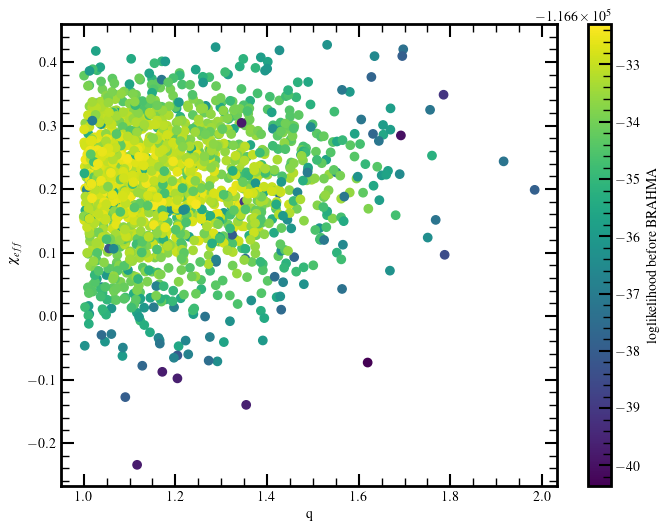

Shape after removing  (1539,)


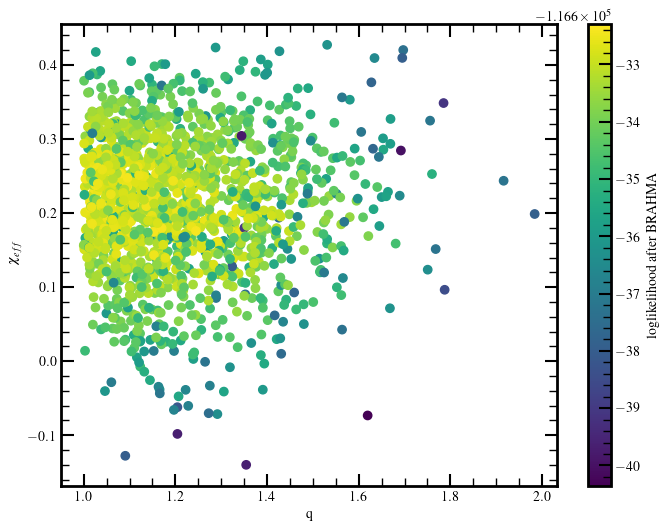

In [ ]:
samples = fp.read_samples(fp["samples"].keys(), temps=0)

loglikelihood = samples["loglikelihood"]
q = samples["q"]
mass1 = samples["mass1"]
chi_eff = samples["chi_eff"]
print("Shape before removing ", len(mass1))

plt.figure()
plt.scatter(q, chi_eff, c=loglikelihood)
plt.xlabel("q")
plt.ylabel("$\chi_{eff}$")
cbar1 = plt.colorbar()
cbar1.set_label("loglikelihood before BRAHMA")
plt.show()


chi_eff = np.delete(samples["chi_eff"], rows, axis=0)
q = np.delete(samples["q"], rows, axis=0)
loglikelihood = np.delete(samples["loglikelihood"], rows, axis=0)
print("Shape after removing ", q.shape)  # Original - 90 credible interval - IBBH limit

plt.figure()
plt.scatter(q, chi_eff, c=loglikelihood)
plt.xlabel("q")
plt.ylabel("$\chi_{eff}$")
cbar2 = plt.colorbar()
cbar2.set_label("loglikelihood after BRAHMA")
plt.show()


In [ ]:
IBBH = (1 / 3) * (Ef - E1 - E2) / (E1 + E2)
rho = 10  # Percentage of fail to be dropped off
limit = 0.5  # Theoretical limit, uniform prior, astrophysical prior

print("Minimum value in IBBH is ", np.min(IBBH))
print("Maximum value in IBBH is ", np.max(IBBH))
print("Shape of IBBH is ", IBBH.shape)
print("Sum of values > 1 of IBBH ", np.sum(IBBH > limit))
print("Sum of values < 0 of IBBH ", np.sum(IBBH < 0))
print(
    "Percentage of IBBH to be removed ",
    (1 - (IBBH.shape[0] * IBBH.shape[1] - (np.sum(IBBH > limit) + np.sum(IBBH < 0))) / (IBBH.shape[0] * IBBH.shape[1]))
    * 100,
)


columns = np.array([])
for i in range(IBBH.shape[1]):
    if np.sum(IBBH[:, i] > limit) >= 1:
        fail = 100 * np.sum(IBBH[:, i] > limit) / IBBH.shape[0]
        # print("Column number number ", i, " percentage of Fail values ", fail)
        if fail >= rho:
            columns = np.append(columns, int(i))
            # IBBH_new = np.delete(IBBH, i, axis=1)
columns = columns.astype(np.int64)
print("Column numbers ", columns)


Minimum value in IBBH is  -0.010585854412618395
Maximum value in IBBH is  0.9443399872655028
Shape of IBBH is  (1770, 85996)
Sum of values > 1 of IBBH  3081950
Sum of values < 0 of IBBH  2
Percentage of IBBH to be removed  2.024763732277124
Column numbers  [   17   251   458   587   669  1013  1543  2075  2101  2398  2551  2802
  3127  3157  3273  3344  3386  3395  3482  3781  4010  4059  4115  4465
  4756  4818  5141  5169  5368  5412  5480  5623  5912  5926  6090  6297
  6341  6505  6736  6952  7007  7449  7511  7545  7686  7800  7929  7964
  8436  8571  8857  8993  9169  9335  9482  9600  9635  9852 10051 10131
 10221 10293 10568 10679 10805 11093 11283 11447 11451 12088 12239 12611
 12728 12813 13011 13377 13689 13726 13812 14437 14662 14729 14821 14884
 14962 15089 15721 15772 15809 15879 15948 15953 16011 16147 16231 16359
 16841 17043 17254 17389 17449 17571 17608 17690 17794 17836 17945 17991
 18075 18132 18322 18543 18570 18750 18928 19106 19161 19192 19279 19285
 19340 19465 

In [ ]:
fpr["samples"].keys()


<KeysViewHDF5 ['amp220', 'amp221', 'f220', 'f221', 'final_mass', 'final_spin', 'inclination', 'logamp220', 'loglikelihood', 'loglikelihood220', 'loglikelihood221', 'lognl', 'logwt', 'phi220', 'phi221', 'polarization', 'tau220', 'tau221']>

Shape before removing  95552
Shape after removing  94931


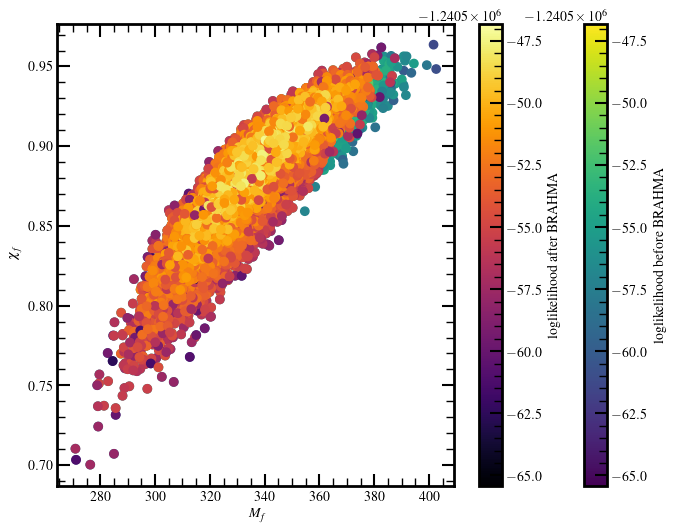

In [ ]:
samples = fpr.read_samples(fpr["samples"].keys(), temps=0)

loglikelihood = samples["loglikelihood"]
final_mass = samples["final_mass"]
final_spin = samples["final_spin"]
print("Shape before removing ", len(final_mass))

plt.scatter(final_mass, final_spin, c=loglikelihood)
cbar1 = plt.colorbar()
cbar1.set_label("loglikelihood before BRAHMA")


final_spin = np.delete(samples["final_spin"], columns, axis=0)
final_mass = np.delete(samples["final_mass"], columns, axis=0)
loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
print("Shape after removing ", len(final_mass))  # Original - 90 credible interval - IBBH limit


plt.scatter(final_mass, final_spin, c=loglikelihood, cmap="inferno")
plt.xlabel("$M_f$")
plt.ylabel("$\chi_{f}$")
cbar1 = plt.colorbar()
cbar1.set_label("loglikelihood after BRAHMA")

plt.show()
